### Project Chicago: Transform ResStock PACKAGE Results for paper to 15 SFD prototypes (Elevate Energy)
Created on: 01/07/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [183]:
import pandas as pd
import pytz
from datetime import datetime


In [197]:
tz_std = pytz.timezone("Etc/GMT+5") #"EST"
tz_local = pytz.timezone("US/Eastern") #"US/Eastern"

In [200]:
year = "2012"
ts = pd.date_range(
    start=datetime(year=int(year), month=1, day=1, hour=0),
    end=datetime(year=int(year), month=12, day=31, hour=23),
    tz=tz_local,
    freq="H"
)
ts
pd.Series(ts).dt.tz_convert(pytz.timezone("Etc/GMT+6"))

0      2011-12-31 23:00:00-06:00
1      2012-01-01 00:00:00-06:00
2      2012-01-01 01:00:00-06:00
3      2012-01-01 02:00:00-06:00
4      2012-01-01 03:00:00-06:00
                  ...           
8779   2012-12-31 18:00:00-06:00
8780   2012-12-31 19:00:00-06:00
8781   2012-12-31 20:00:00-06:00
8782   2012-12-31 21:00:00-06:00
8783   2012-12-31 22:00:00-06:00
Length: 8784, dtype: datetime64[ns, Etc/GMT+6]

In [188]:
year = "2012"
ts = pd.date_range(
    start=datetime(year=int(year), month=1, day=1, hour=0),
    end=datetime(year=int(year), month=12, day=31, hour=23),
    tz=tz_std,
    freq="H"
)
ts

DatetimeIndex(['2012-01-01 00:00:00-05:00', '2012-01-01 01:00:00-05:00',
               '2012-01-01 02:00:00-05:00', '2012-01-01 03:00:00-05:00',
               '2012-01-01 04:00:00-05:00', '2012-01-01 05:00:00-05:00',
               '2012-01-01 06:00:00-05:00', '2012-01-01 07:00:00-05:00',
               '2012-01-01 08:00:00-05:00', '2012-01-01 09:00:00-05:00',
               ...
               '2012-12-31 14:00:00-05:00', '2012-12-31 15:00:00-05:00',
               '2012-12-31 16:00:00-05:00', '2012-12-31 17:00:00-05:00',
               '2012-12-31 18:00:00-05:00', '2012-12-31 19:00:00-05:00',
               '2012-12-31 20:00:00-05:00', '2012-12-31 21:00:00-05:00',
               '2012-12-31 22:00:00-05:00', '2012-12-31 23:00:00-05:00'],
              dtype='datetime64[ns, EST]', length=8784, freq='H')

In [145]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [146]:
# local path to downloaded results
iteration = 'elevate_all'
iter_path = f'cookcnty_packages_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir, iter_path)

# number of upgrades
if iteration == 'paper_all':
    N_upgrades = 10
elif iteration == 'elevate_all':
    N_upgrades = 19
else:
    raise ValueError(f"iteration={iteration} does not have a specified 'N_upgrades'")

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'processed csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Results path: \n   {result_path}')


Results path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_elevate_all


### Functions

In [147]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui_thermpersqft'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui_kwhpersqft'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui_kbtupersqft'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
    
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')

def load_upgrade(n, file_dir=result_path):
    """
    ARG:
        n (int, str): upgrade number
        file_dir (str): folder in which upgrade can be found, default to main result dir
    RETURN:
        df (dataframe) of upgrade n
    """
    df = pd.read_parquet(os.path.join(file_dir,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    return df
print('func loaded: "load_upgrade"')



func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"
func loaded: "load_upgrade"


### 1. BASELINE results

In [178]:
save_a_copy_in_csv = True # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)

if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)
    
# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

# check
n_bldgs = 40000
jobs_missing = set(range(1,100)) - set(res.job_id.unique())
print(f'- {len(jobs_missing)} jobs missing: {jobs_missing}')
print(f'- {n_bldgs-len(res)} buildings ({((n_bldgs-len(res))/n_bldgs*100):.2f}%)')

res

- 0 jobs missing: set()
- 0 buildings (0.00%)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft
0,1,182,2021-07-17 06:38:18,2021-07-17 06:39:49,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.909091,18.272727,18.471290,14.904212,4697.0,20.325657,885.0,1.148604,11.168538,152.941590
1,2,175,2021-07-17 10:31:28,2021-07-17 10:32:56,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.545455,18.090909,32.122713,22.346864,4721.0,34.274634,1138.0,1.362495,9.550067,168.803238
2,3,26,2021-07-17 11:32:02,2021-07-17 11:33:38,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.090909,18.454545,16.643373,9.903358,4721.0,18.064943,3301.0,0.458077,3.038798,56.165555
3,4,103,2021-07-17 10:39:48,2021-07-17 10:55:06,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.727273,15.636364,168.493217,163.525355,67.0,264.587808,1138.0,0.452752,4.975450,62.241314
4,5,68,2021-07-17 10:52:14,2021-07-17 10:53:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.727273,18.454545,12.295530,9.090699,4743.0,14.355050,1690.0,0.676681,4.275923,82.242037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,177,2021-07-17 02:22:19,2021-07-17 02:23:43,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.181818,17.181818,16.726834,8.380572,4936.0,18.167156,1690.0,1.362283,4.771241,152.475934
39996,39997,118,2021-07-17 02:59:12,2021-07-17 03:00:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.454545,16.636364,30.117522,32.788914,5847.0,40.114838,1220.0,1.193912,6.134545,140.294666
39997,39998,70,2021-07-17 09:52:36,2021-07-17 10:42:58,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,19.454545,18.363636,230.453932,156.743661,5156.0,248.454906,617.0,0.341858,5.242680,52.066389
39998,39999,17,2021-07-17 10:45:42,2021-07-17 10:47:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,16.909091,30.702417,12.548283,5057.0,32.450452,8194.0,0.444842,2.092234,51.612577


In [149]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [150]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_packages_elevate_all - BASELINE result summary:

  * 39976 / 40000 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.525790
2            0.260106
3            0.214103
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.715204
WoodStud     0.284796
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.235066
1960-79      0.255003
1980-99      0.137833
2000-09      0.076146
2010s        0.011682
<1940        0.284271
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.616595
Heat Pump      0.025615
None           0.052206
Room AC        0.305583
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity

### 1.2. Add additional metrics to Baseline

In [151]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories
0,1,182,2021-07-17 06:38:18,2021-07-17 06:39:49,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.471290,14.904212,4697.0,20.325657,885.0,1.148604,11.168538,152.941590,2: 1942-1978,1: <2 stories
1,2,175,2021-07-17 10:31:28,2021-07-17 10:32:56,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,32.122713,22.346864,4721.0,34.274634,1138.0,1.362495,9.550067,168.803238,2: 1942-1978,1: <2 stories
2,3,26,2021-07-17 11:32:02,2021-07-17 11:33:38,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.643373,9.903358,4721.0,18.064943,3301.0,0.458077,3.038798,56.165555,3: post-1978,2: 2+ stories
3,4,103,2021-07-17 10:39:48,2021-07-17 10:55:06,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,168.493217,163.525355,67.0,264.587808,1138.0,0.452752,4.975450,62.241314,2: 1942-1978,2: 2+ stories
4,5,68,2021-07-17 10:52:14,2021-07-17 10:53:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.295530,9.090699,4743.0,14.355050,1690.0,0.676681,4.275923,82.242037,3: post-1978,2: 2+ stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,177,2021-07-17 02:22:19,2021-07-17 02:23:43,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.726834,8.380572,4936.0,18.167156,1690.0,1.362283,4.771241,152.475934,1: pre-1942,2: 2+ stories
39996,39997,118,2021-07-17 02:59:12,2021-07-17 03:00:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.117522,32.788914,5847.0,40.114838,1220.0,1.193912,6.134545,140.294666,2: 1942-1978,1: <2 stories
39997,39998,70,2021-07-17 09:52:36,2021-07-17 10:42:58,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,230.453932,156.743661,5156.0,248.454906,617.0,0.341858,5.242680,52.066389,3: post-1978,2: 2+ stories
39998,39999,17,2021-07-17 10:45:42,2021-07-17 10:47:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.702417,12.548283,5057.0,32.450452,8194.0,0.444842,2.092234,51.612577,1: pre-1942,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [152]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [153]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [154]:
res2 = []

for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        res_group_i['prototype'] = row['HousingGroupName']
        res2.append(res_group_i)

res2 = pd.concat(res2, axis=0).sort_values(by=['building_id'])
display(res2)

res2 = res2.set_index('building_id').reindex(res['building_id']).reset_index()
res.loc[res2['prototype'].isnull(),:]

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories,prototype
0,1,182,2021-07-17 06:38:18,2021-07-17 06:39:49,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.904212,4697.0,20.325657,885.0,1.148604,11.168538,152.941590,2: 1942-1978,1: <2 stories,Masonry 1942-1978 Less than 2 Stories
2,3,26,2021-07-17 11:32:02,2021-07-17 11:33:38,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.903358,4721.0,18.064943,3301.0,0.458077,3.038798,56.165555,3: post-1978,2: 2+ stories,Masonry Post-1978 2 or more stories
4,5,68,2021-07-17 10:52:14,2021-07-17 10:53:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.090699,4743.0,14.355050,1690.0,0.676681,4.275923,82.242037,3: post-1978,2: 2+ stories,Frame Post-1978 2 or more stories
5,6,196,2021-07-17 04:59:04,2021-07-17 05:00:29,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.852629,4002.0,12.591113,2176.0,0.578723,4.654535,73.740477,2: 1942-1978,1: <2 stories,Frame 1942-1978 less than 2 stories
6,7,83,2021-07-17 04:52:36,2021-07-17 04:53:58,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,27.958085,138.0,30.585420,1690.0,0.000000,11.631914,39.689707,3: post-1978,1: <2 stories,Frame Post-1978 Less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39989,39990,5,2021-07-17 11:05:33,2021-07-17 11:07:05,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,24.971367,4430.0,39.386733,2176.0,0.769915,4.136356,91.086965,1: pre-1942,2: 2+ stories,Frame Pre-1942 2 or more stories
39993,39994,138,2021-07-17 02:43:15,2021-07-17 02:44:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.566405,4795.0,19.721980,1220.0,1.702029,8.437460,198.952108,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories
39995,39996,177,2021-07-17 02:22:19,2021-07-17 02:23:43,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,8.380572,4936.0,18.167156,1690.0,1.362283,4.771241,152.475934,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories
39998,39999,17,2021-07-17 10:45:42,2021-07-17 10:47:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.548283,5057.0,32.450452,8194.0,0.444842,2.092234,51.612577,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories
1,2,175,2021-07-17 10:31:28,2021-07-17 10:32:56,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,32.122713,22.346864,4721.0,34.274634,1138.0,1.362495,9.550067,168.803238,2: 1942-1978,1: <2 stories
3,4,103,2021-07-17 10:39:48,2021-07-17 10:55:06,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,168.493217,163.525355,67.0,264.587808,1138.0,0.452752,4.975450,62.241314,2: 1942-1978,2: 2+ stories
9,10,192,2021-07-17 04:39:28,2021-07-17 04:42:47,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,99.423338,80.785095,5156.0,110.199843,2115.0,0.588600,5.599963,77.953851,1: pre-1942,1: <2 stories
11,12,26,2021-07-17 06:25:19,2021-07-17 06:26:47,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,23.689307,16.190775,4626.0,26.813113,853.0,0.772902,7.783478,103.830044,2: 1942-1978,1: <2 stories
12,13,161,2021-07-17 05:12:35,2021-07-17 05:32:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,274.765462,659.511291,621.0,857.943488,853.0,0.000000,17.114553,58.397232,3: post-1978,2: 2+ stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39991,39992,181,2021-07-17 04:55:50,2021-07-17 05:42:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,706.134843,1010.556157,656.0,1139.012553,617.0,0.031215,20.504050,73.083445,3: post-1978,2: 2+ stories
39992,39993,77,2021-07-17 06:59:41,2021-07-17 07:14:31,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,1248.149351,1180.663489,7124.0,1364.992653,1138.0,0.431626,5.243992,61.045589,3: post-1978,2: 2+ stories
39994,39995,89,2021-07-17 10:18:42,2021-07-17 10:29:30,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,150.472590,778.825602,630.0,903.492684,853.0,0.000000,19.504706,66.552768,3: post-1978,2: 2+ stories
39996,39997,118,2021-07-17 02:59:12,2021-07-17 03:00:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.117522,32.788914,5847.0,40.114838,1220.0,1.193912,6.134545,140.294666,2: 1942-1978,1: <2 stories


In [155]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [156]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui_thermpersqft', 
               'median elec eui': 'elec_eui_kwhpersqft'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui_thermpersqft', 
               'mean elec eui': 'elec_eui_kwhpersqft'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2394.582482,809.300248,894.328320,0.406565,0.437425,8440.908464,9490.695598,4.045183,4.674855
2,Masonry All Years Split Level,1690.0,2000.196867,1159.500556,1284.788947,0.692642,0.735941,8613.460399,9980.685125,5.060845,5.833191
3,Masonry Post-1978 2 or more stories,3301.0,4058.270428,1325.578192,1360.604418,0.386588,0.417655,11120.192073,13035.594131,3.388044,3.860661
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1680.132653,1041.383441,1136.216561,0.690092,0.723652,8144.409523,9195.575224,5.272976,6.023705
5,Masonry 1942-1978 2 or more stories,2176.0,2392.638539,1582.226413,1668.731574,0.759064,0.785282,9717.535432,11408.271663,4.647898,5.536747
6,Masonry Pre-1942 less than 2 stories,1220.0,1460.060606,1360.328234,1432.472334,1.016638,1.061277,8265.619916,9336.781699,6.323611,6.988451
7,Masonry Pre-1942 2 or more stories,2176.0,2552.909881,1820.494897,1970.774883,0.872336,0.909832,10238.766498,12595.313692,4.876909,6.005236
8,Frame Post-1978 Less than 2 stories,2176.0,2243.300336,861.393384,937.391628,0.456008,0.480849,8321.654238,9477.607888,4.369729,4.946224
9,Frame Post-1978 Split Level,2176.0,3012.053452,1093.375863,1218.852275,0.465842,0.484174,9351.585828,11310.340488,3.851808,4.538984


In [157]:
### export BASELINE prototype summary
groups.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_elevate_all/baseline


## 2B. PACKAGE summary ###

In [158]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(upkg_no, p, ref, HVAC_upgrades_rate_change, for_packages=False):
    
    res = ref.set_index('building_id')[['gas_rate', 'gas_fixed', 'gas_CO2_rate',
                                        'elec_rate', 'elec_fixed', 'elec_CO2_rate'
                                       ]]
    ## assign rates
    p['gas_rate'] = p['building_id'].map(res['gas_rate'])
    p['gas_fixed'] = p['building_id'].map(res['gas_fixed'])
    p['gas_CO2_rate'] = p['building_id'].map(res['gas_CO2_rate'])
    p['elec_rate'] = p['building_id'].map(res['elec_rate'])
    p['elec_fixed'] = p['building_id'].map(res['elec_fixed'])
    p['elec_CO2_rate'] = p['building_id'].map(res['elec_CO2_rate'])
    
    if not for_packages:
        # ind upgrades
        for n in HVAC_upgrades_rate_change.keys():
            new_rates = HVAC_upgrades_rate_change[n]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
    else:
        if isinstance(HVAC_upgrades_rate_change, dict):
            # packages with a dict input
            if upkg_no in HVAC_upgrades_rate_change.keys():
                for m in HVAC_upgrades_rate_change[upkg_no]:
                    idx = (p[(p['apply_upgrade.applicable']==True) &
                           (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                            ]).index
                    p.loc[idx, 'gas_rate'] = NGH_rate
                    p.loc[idx, 'gas_fixed'] = NGH_fixed
                    p.loc[idx, 'elec_rate'] = EH_rate
                    p.loc[idx, 'elec_fixed'] = EH_fixed
        
        else:
            # packages with a list input
            for m in HVAC_upgrades_rate_change:
                idx = (p[(p['apply_upgrade.applicable']==True) &
                       (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                        ]).index
                p.loc[idx, 'gas_rate'] = NGH_rate
                p.loc[idx, 'gas_fixed'] = NGH_fixed
                p.loc[idx, 'elec_rate'] = EH_rate
                p.loc[idx, 'elec_fixed'] = EH_fixed
                
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan

    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """ 
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed'] - \
        (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
        
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed'] - \
        (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [159]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 * 12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.10726, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.12621, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh (0.2446 tons/mbtu)

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 * 12
NGH_fixed = 21.51 * 12
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm (0.0532 tons/mbtu)

### upgrades that will cause utility rate change: ###########################################
if iteration == 'paper_all':
    HVAC_upgrades_rate_change = {
        6: [24,25,26,27], # elec basic
        7: [24,25,26,27,28,29,30], # elec HP,
        8: [26,27,28,29,30,31,32], # elec HP + eff,
        10: [47,48,49,50,51,52,53], # full upgrade ele
    }
elif iteration == 'elevate_all':
    # all packages below seem indiscriminant between electric and gas
    HVAC_upgrades_rate_change = {
        12: [5, 6, 7], # Electrification - Gas to ASHP
        13: [5, 6, 7, 8], # Electrification - Gas to MSHP
        14: [5, 6, 7], # Electrification - Electric to ASHP, 
        15: [5, 6, 7, 8], # Electrification - Electric to MSHP
        16: [5, 6, 7], # Electrification - Gas to ASHP (Low-Gain Window)
        17: [5, 6, 7, 8], # Electrification - Gas to MSHP (Low-Gain Window)
        18: [5, 6, 7], # Electrification - Electric to ASHP (Low-Gain Window)
        19: [5, 6, 7, 8], # Electrification - Electric to MSHP (Low-Gain Window)
    }
    
else:
    raise ValueError(f"iteration = {iteration} does not have an HVAC_upgrades_rate_change defined")

    
# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed

# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


In [160]:
(0.10273*4+0.10952*8)/12

0.10725666666666667

In [161]:
(0.12168*4+0.12847*8)/12

0.12620666666666666

### Get baseline results

In [162]:
#### count upgrades
print(f'>>> {iter_path} has {N_upgrades:,} packages')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
    
## get summary table
summary_upgrades = []
package_list = list(range(1,N_upgrades+1))
for n in package_list:
    p = pd.read_parquet(os.path.join(result_path, 'upgrades', f'upgrade={n}',
                                     f'results_up{n:02d}.parquet'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)


    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### export upgrade results to csv 
    p.to_csv(os.path.join(combined_res_csv_path, f'results_package{n:02d}{fn_ext}.csv'), index=False)
    
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc
        
    ### add to summary table
    summ = pd.DataFrame()
    summ.loc[0,'upgrade_no'] = n
    summ.loc[0,'upgrade_name'] = upgrade_name
    summ.loc[0,'n_applied'] = len(p)
    summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
    summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
    summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

    p = p[p['completed_status']=='Success'].reset_index(drop=True)
    summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
    summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
    summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
    summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
    summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
    summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
    summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
    summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
    summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
    summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)

    summ['median_simple_payback'] = round(p['simple_payback'].median(),3)
    
    p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
    summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
    summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)

    # filter: min 1 cent energy cost savings **
    min_energy_cost_saving = 0.1 # <----- **
    summ['pct_pos_simple_payback_filtered'] = round(len(
        p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
    )/len(p)*100, 3)
    summ['mean_pos_simple_payback_filtered'] = round(
        p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
           'simple_payback'].mean(),3)

    summary_upgrades.append(summ)
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_packages_elevate_all has 19 packages
Natural gas rate multiplier: 1

Package 1
min      -316101.693015
median        16.323076
max        27282.280754
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 846 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 619 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 639 carbon saving<0 

Package 2
min      -18389.815404
median       27.384757
max       28454.141186
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 450 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 20 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 12 carbon saving<0 

Package 3
min       -3684.449139
median       32.578195
max       27789.794895
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=3 has 428 simple_payback>100 (including 0 INF)
   

,upgrade_no,upgrade_name,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,mean_ann_mbtu_site_energy_saving,mean_pct_delta_gas_eui,...,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered
0,1.0,Utility Incentive Shell + LEDs,39976.0,39975.0,0.0,99.997,179.313,1012.093,21.585,-14.677,...,-14.123,3672.92,5.387,233.06,1.799,16.323,98.452,30.021,98.444,29.318
1,2.0,Utility Incentive Shell + LEDs - Forced Air,39976.0,26356.0,0.0,65.930,377.916,924.457,40.937,-32.816,...,-28.353,8422.89,4.488,348.65,2.783,27.385,99.924,35.401,99.924,35.401
2,3.0,Utility Incentive Shell + LEDs + Appliances - ...,39976.0,26356.0,0.0,65.930,385.724,1140.743,42.456,-33.568,...,-29.615,10859.67,3.604,380.75,3.005,32.578,99.992,38.620,99.992,38.620
3,4.0,Utility Incentive Shell + WH - Hydronic,39976.0,3749.0,0.0,9.378,534.805,843.499,56.346,-40.061,...,-34.882,12364.08,4.214,436.15,3.550,32.864,100.000,36.786,100.000,36.786
4,5.0,Utility Incentive Shell + LEDs + Appliances - ...,39976.0,3749.0,0.0,9.378,543.640,1065.051,57.985,-40.816,...,-36.082,14884.94,3.618,469.56,3.782,36.251,100.000,39.840,100.000,39.840
5,6.0,Comprehensive - Forced Air + WH + Shell,39976.0,26356.0,0.0,65.930,381.264,933.055,41.301,-33.089,...,-28.585,8815.78,4.355,351.80,2.808,28.343,99.958,35.810,99.958,35.810
6,7.0,Comprehensive - Forced Air + WH + Insulation +...,39976.0,26356.0,0.0,65.930,403.798,856.722,43.293,-35.378,...,-30.157,10913.21,3.752,356.01,2.864,34.447,99.894,45.820,99.894,45.820
7,8.0,Comprehensive - Hydronic + WH + Shell,39976.0,3749.0,0.0,9.378,538.337,850.118,56.722,-40.321,...,-35.105,12796.12,4.109,439.16,3.575,33.566,100.000,37.588,100.000,37.588
8,9.0,Comprehensive - Hydronic + WH + Shell + Applia...,39976.0,3749.0,0.0,9.378,563.023,759.260,58.880,-42.514,...,-36.636,15031.43,3.658,442.92,3.630,39.129,100.000,44.501,100.000,44.501
9,10.0,Comprehensive - ASHP,39974.0,26354.0,0.0,65.928,924.753,-5518.439,73.624,-81.944,...,-52.314,12226.48,5.683,-130.57,0.315,-26.159,39.057,671.112,39.034,498.116


In [163]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_elevate_all/processed results


In [164]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
upgrade_list = range(1, 2+1) # [8] # <----- list of upgrades to convert to csv

if save_to_csv:
    for n in upgrade_list:
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.csv'), index=False)
        print(f'upgrade {n:02d} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [165]:
# (1) combine baseline results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
### add totals metrics:
res = get_annual_totals(res)
res['apply_upgrade.upgrade_name'] = 'Baseline'

## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')

res_proto_upgrades = []
for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        
        ## add tags
#         res_group_i['build_existing_model.sample_weight'] = row['Chicago Prevalence']*100/len(res_group_i)
        res_group_i['package_no'] = 0
        res_group_i['HousingGroupNo'] = row['HousingGroupNo']
        res_group_i['HousingGroupName'] = row['HousingGroupName']

        res_proto_upgrades.append(res_group_i)

res_proto_upgrades = pd.concat(res_proto_upgrades, axis=0).reset_index(drop=True)
print(f'SFD: {len(res_proto_upgrades)}')
res_others = res.loc[(res['completed_status']=='Success') &
            (res['build_existing_model.geometry_building_type_recs']!='Single-Family Detached')
           ].reset_index(drop=True)
print(f'Others: {len(res_others)}')
res_proto_upgrades = pd.concat([
    res_proto_upgrades,
    res_others], axis=0).sort_values(by=['building_id']).reset_index(drop=True)

display(res_proto_upgrades)

Natural gas rate multiplier: 1
prototypes loaded
SFD: 16753
Others: 23223


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,package_no,HousingGroupNo,HousingGroupName
0,1,182,2021-07-17 06:38:18,2021-07-17 06:39:49,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1170.500631,1418.806375,2589.307006,5.409695,8.250325,13.660020,0.0,4.0,Masonry 1942-1978 Less than 2 Stories
1,2,175,2021-07-17 10:31:28,2021-07-17 10:32:56,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1499.704468,1542.971035,3042.675503,8.251572,9.071521,17.323093,NaN,NaN,NaN
2,3,26,2021-07-17 11:32:02,2021-07-17 11:33:38,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1476.026235,1437.348336,2913.374571,8.047168,8.372957,16.420125,0.0,3.0,Masonry Post-1978 2 or more stories
3,4,103,2021-07-17 10:39:48,2021-07-17 10:55:06,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,861.469920,885.949918,1747.419838,2.741964,4.726134,7.468098,NaN,NaN,NaN
4,5,68,2021-07-17 10:52:14,2021-07-17 10:53:42,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1248.841076,1083.368538,2332.209614,6.085975,6.031816,12.117791,0.0,10.0,Frame Post-1978 2 or more stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39971,39996,177,2021-07-17 02:22:19,2021-07-17 02:23:43,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1963.135688,1189.014581,3152.150270,12.252177,6.730534,18.982711,0.0,7.0,Masonry Pre-1942 2 or more stories
39972,39997,118,2021-07-17 02:59:12,2021-07-17 03:00:39,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1441.787849,1115.908960,2557.696809,7.751602,6.247031,13.998633,NaN,NaN,NaN
39973,39998,70,2021-07-17 09:52:36,2021-07-17 10:42:58,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,673.871824,579.604973,1253.476796,1.122510,2.700039,3.822548,NaN,NaN,NaN
39974,39999,17,2021-07-17 10:45:42,2021-07-17 10:47:25,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2790.930568,2335.017280,5125.947848,19.398178,14.309934,33.708112,0.0,7.0,Masonry Pre-1942 2 or more stories


In [166]:
# (2) combine upgrade results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = []

package_list = list(range(1,N_upgrades+1))
for n in package_list:
    p = pd.read_parquet(os.path.join(result_path, 'upgrades', f'upgrade={n}',
                                     f'results_up{n:02d}.parquet'))
    print(f'\nPackage {n}')

    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)

    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### add totals metrics:
    p = get_annual_totals(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)

    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)

    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    
    ### get results by prototype
    for i, row in groups.iterrows():
        if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
            pi = get_res_by_prototype(p, res, row) # <----

            ### subset to only those that have been applied with the upgrades successfully:
            pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)
        
    ### get results by all others
    p_others = p.loc[
        (p['completed_status']=='Success') &
        (res['build_existing_model.geometry_building_type_recs']!='Single-Family Detached')
           ].reset_index(drop=True)
    all_proto_upgrades.append(p_others)

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).sort_values(by=['building_id']).reset_index(drop=True)

aa = all_proto_upgrades.copy()
aa['build_existing_model.geometry_building_type_recs'] = aa['building_id'].map(
    res.set_index('building_id')['build_existing_model.geometry_building_type_recs'])

print('\n# of upgrades by building types:')
print(
    res.groupby(['apply_upgrade.upgrade_name',
                   'build_existing_model.geometry_building_type_recs'])['building_id'].count()
)
print(
    aa.groupby(['package_no',
                'apply_upgrade.upgrade_name',
                'build_existing_model.geometry_building_type_recs'])['building_id'].count()
)
all_proto_upgrades


Natural gas rate multiplier: 1

Package 1
min      -316101.693015
median        16.323076
max        27282.280754
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 846 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 619 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 639 carbon saving<0 

Package 2
min      -18389.815404
median       27.384757
max       28454.141186
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 450 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 20 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 12 carbon saving<0 

Package 3
min       -3684.449139
median       32.578195
max       27789.794895
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=3 has 428 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=3 has 2 simple_pay

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName
0,1,47,2021-07-17 09:32:01,2021-07-17 09:35:00,Success,True,Utility Incentive Shell + LEDs,,True,20.0,...,94.603189,150.482694,4.027112,19.174298,0.482384,0.625684,1.108068,1,4.0,Masonry 1942-1978 Less than 2 Stories
1,1,49,2021-07-17 07:34:23,2021-07-17 07:38:00,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,20.0,...,99.563945,226.394781,4.573939,22.462532,1.094877,0.658493,1.753370,2,4.0,Masonry 1942-1978 Less than 2 Stories
2,1,66,2021-07-17 02:29:56,2021-07-17 02:34:08,Success,True,Utility Incentive Shell + LEDs + Appliances - ...,,True,20.0,...,145.573716,274.785069,3.156503,28.696610,1.115427,0.962791,2.078218,3,4.0,Masonry 1942-1978 Less than 2 Stories
3,1,150,2021-07-17 02:20:46,2021-07-17 02:27:05,Success,True,Electrification - Gas to ASHP,,True,20.0,...,-515.327598,655.173034,5.992274,20.330370,5.409695,-5.335475,0.074220,12,4.0,Masonry 1942-1978 Less than 2 Stories
4,1,161,2021-07-17 03:32:46,2021-07-17 03:39:21,Success,True,Electrification - Gas to ASHP (Low-Gain Window),,True,20.0,...,-485.803406,684.697225,4.405435,26.772345,5.409695,-5.105710,0.303985,16,4.0,Masonry 1942-1978 Less than 2 Stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286885,40000,17,2021-07-17 07:49:07,2021-07-17 07:52:25,Success,True,Utility Incentive Shell + LEDs,,True,20.0,...,229.920299,307.988548,2.970227,20.634858,0.673930,1.520640,2.194570,1,4.0,Masonry 1942-1978 Less than 2 Stories
286886,40000,57,2021-07-17 07:52:14,2021-07-17 07:56:38,Success,True,Comprehensive - ASHP,,True,20.0,...,-624.079602,-57.213681,5.113389,-256.557694,4.893513,-4.127520,0.765993,10,4.0,Masonry 1942-1978 Less than 2 Stories
286887,40000,178,2021-07-17 05:20:09,2021-07-17 05:25:29,Success,True,Comprehensive - Forced Air + WH + Insulation +...,,True,20.0,...,203.796750,412.642691,2.649839,36.013942,1.802878,1.347865,3.150743,7,4.0,Masonry 1942-1978 Less than 2 Stories
286888,40000,15,2021-07-17 05:20:52,2021-07-17 05:25:13,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,20.0,...,241.514095,408.057408,2.955863,27.805867,1.437698,1.597319,3.035017,2,4.0,Masonry 1942-1978 Less than 2 Stories


In [167]:
# (3) combine upgrade and baseline (results by non-split-level prototypes (N=12))
cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" df saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" df saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName
0,1,47,2021-07-17 09:32:01,2021-07-17 09:35:00,Success,True,Utility Incentive Shell + LEDs,,True,20.000000,...,94.603189,150.482694,4.027112,19.174298,0.482384,0.625684,1.108068,1.0,4.0,Masonry 1942-1978 Less than 2 Stories
1,1,49,2021-07-17 07:34:23,2021-07-17 07:38:00,Success,True,Utility Incentive Shell + LEDs - Forced Air,,True,20.000000,...,99.563945,226.394781,4.573939,22.462532,1.094877,0.658493,1.753370,2.0,4.0,Masonry 1942-1978 Less than 2 Stories
2,1,66,2021-07-17 02:29:56,2021-07-17 02:34:08,Success,True,Utility Incentive Shell + LEDs + Appliances - ...,,True,20.000000,...,145.573716,274.785069,3.156503,28.696610,1.115427,0.962791,2.078218,3.0,4.0,Masonry 1942-1978 Less than 2 Stories
3,1,150,2021-07-17 02:20:46,2021-07-17 02:27:05,Success,True,Electrification - Gas to ASHP,,True,20.000000,...,-515.327598,655.173034,5.992274,20.330370,5.409695,-5.335475,0.074220,12.0,4.0,Masonry 1942-1978 Less than 2 Stories
4,1,161,2021-07-17 03:32:46,2021-07-17 03:39:21,Success,True,Electrification - Gas to ASHP (Low-Gain Window),,True,20.000000,...,-485.803406,684.697225,4.405435,26.772345,5.409695,-5.105710,0.303985,16.0,4.0,Masonry 1942-1978 Less than 2 Stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326861,39996,177,2021-07-17 02:22:19,2021-07-17 02:23:43,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,Masonry Pre-1942 2 or more stories
326862,39997,118,2021-07-17 02:59:12,2021-07-17 03:00:39,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326863,39998,70,2021-07-17 09:52:36,2021-07-17 10:42:58,Success,None,Baseline,,True,6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326864,39999,17,2021-07-17 10:45:42,2021-07-17 10:47:25,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,Masonry Pre-1942 2 or more stories


In [168]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status',
                        'package_no','HousingGroupNo','HousingGroupName']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)
    
    cols_to_drop = [x for x in res_proto_meta.columns if 
                    x.startswith('simulation_output_report.option') or
                    x == 'simulation_output_report.upgrade_cost_usd']
    
    res_proto_meta = res_proto_meta.drop(cols_to_drop, axis=1)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)

    print('"res_proto_meta" df saved')
    display(res_proto_meta)
    

"res_proto_meta" df saved


,HousingGroupName,HousingGroupNo,build_existing_model.ahs_region,build_existing_model.applicable,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.bathroom_spot_vent_hour,build_existing_model.bedrooms,build_existing_model.building_america_climate_zone,build_existing_model.ceiling_fan,build_existing_model.census_division,...,build_existing_model.vintage,build_existing_model.vintage_acs,build_existing_model.water_heater,build_existing_model.window_areas,build_existing_model.windows,building_id,completed_status,package_no,stories,vintage_ee
0,Masonry 1942-1978 Less than 2 Stories,4.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour20,4,Cold,Standard Efficiency,East North Central,...,1950s,1940-59,Gas Standard,F9 B9 L9 R9,2+ Pane,1,Success,0.0,1: <2 stories,2: 1942-1978
1,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour14,3,Cold,Standard Efficiency,East North Central,...,1940s,1940-59,Gas Standard,F12 B12 L12 R12,2+ Pane,2,Success,NaN,1: <2 stories,2: 1942-1978
2,Masonry Post-1978 2 or more stories,3.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour5,3,Cold,Standard Efficiency,East North Central,...,1980s,1980-99,Gas Standard,F30 B30 L30 R30,2+ Pane,3,Success,0.0,2: 2+ stories,3: post-1978
3,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,2,Cold,Standard Efficiency,East North Central,...,1950s,1940-59,Gas Standard,F30 B30 L30 R30,2+ Pane,4,Success,NaN,2: 2+ stories,2: 1942-1978
4,Frame Post-1978 2 or more stories,10.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,5,Cold,Standard Efficiency,East North Central,...,1980s,1980-99,Gas Standard,F9 B9 L9 R9,2+ Pane,5,Success,0.0,2: 2+ stories,3: post-1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39971,Masonry Pre-1942 2 or more stories,7.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour6,3,Cold,None,East North Central,...,<1940,<1940,Gas Standard,F12 B12 L12 R12,2+ Pane,39996,Success,0.0,2: 2+ stories,1: pre-1942
39972,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour2,2,Cold,Standard Efficiency,East North Central,...,1970s,1960-79,Gas Standard,F30 B30 L30 R30,1 Pane,39997,Success,NaN,1: <2 stories,2: 1942-1978
39973,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,1,Cold,Standard Efficiency,East North Central,...,1990s,1980-99,Gas Standard,F12 B12 L12 R12,1 Pane,39998,Success,NaN,2: 2+ stories,3: post-1978
39974,Masonry Pre-1942 2 or more stories,7.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour10,5,Cold,None,East North Central,...,<1940,<1940,Gas Standard,F12 B12 L12 R12,2+ Pane,39999,Success,0.0,2: 2+ stories,1: pre-1942


### 2.2. Get PACKAGE results by building prototypes from Elevate Energy

In [169]:
combine_all_upgrades_and_export_as_csv = True # <------ used to plot distributions

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui_thermpersqft',
               'mean_elec_eui kwh_per_sqft': 'elec_eui_kwhpersqft',
               'mean_site_eui kbtu_per_sqft': 'site_eui_kbtupersqft'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups2.columns)

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = []

### (3) add upgrades results
package_list = list(range(1,N_upgrades+1))
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_parquet(os.path.join(result_path, 'upgrades', f'upgrade={n}',
                                     f'results_up{n:02d}.parquet'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)


    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)
        
        if combine_all_upgrades_and_export_as_csv:
            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)
        
        for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui','ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].replace(
                [np.inf, -np.inf], np.nan).mean(), 3)
        for var in ['upgrade_cost', 'ann_kbtu_saved_per_dollar','ann_energy_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 2)
        for var in ['simple_payback']:
            n_cp = len(pi[~pi[var].isnull()])
            if n_cp>0:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].median(), 2)
                pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                
                # filter: min 1 cent energy cost savings **
                min_energy_cost_saving = 0.1 # <----- ** 
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(len(
                    pi[(pi[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
                    )/n_cp*100, 3)
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(
                    pi.loc[(pi[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving),var].mean(), 2)
            else:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
        
if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = pd.concat(all_proto_upgrades).reset_index(drop=True).replace('',np.nan).dropna(axis=1, how='all')
    all_proto_upgrades.to_csv(os.path.join(result_path,'processed results',f'all_upgrades_by_prototype_combined{fn_ext}.csv'), index=False)
    print(f'\nall {len(package_list)} UPGRADEs are combined and saved to:\n  {os.path.join(result_path, "processed results")}')            

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


Natural gas rate multiplier: 1
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 40000

Package 1
min      -316101.693015
median        16.323076
max        27282.280754
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 846 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 619 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 639 carbon saving<0 

Package 2
min      -18389.815404
median       27.384757
max       28454.141186
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 450 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 20 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 12 carbon saving<0 

Package 3
min       -3684.449139
median       32.578195
max       27789.794895
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=3 has 428

Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.437425   
1              0.019980  9128.0                    0.735941   
2              0.032967   514.0                    0.417655   
3              0.191808  5488.0                    0.723652   
4              0.045954   794.0                    0.785282   
5              0.073926   726.0                    1.061277   
6              0.021978   921.0                    0.909832   
7              0.015984   596.0                    0.480849   
8              0.021978  1347.0                    0.484174   
9              0.087912   751.0                    0.486814   
10             0.183816  3012.0                    0.762576   
11             0.064935  2128.0                    1.086607   
12             0.066933  1138.0                    0.898862   
13             0.109890   703.0                    1.168791   
14             0.048951  1425.0                    1.046063   

                               ...      pct_pos_simple_payback  \
   mean_elec_eui kwh_per_sqft  ... pkg10: Comprehensive - ASHP   
0                    4.674855  ...                      39.593   
1                    5.833191  ...                      22.287   
2                    3.860661  ...                      14.105   
3                    6.023705  ...                      20.983   
4                    5.

In [170]:
### export prototype UPGRADE summary
groups2.to_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_elevate_all/processed results


### Get baseline totals for comparison

### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [171]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups2 = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'),
                         header=[0, 1])
    
    print(f'"groups2{fn_ext}" df loaded from file.')
    display(groups2)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_elevate_all/processed results/plots/mean_values_by_prototype

>> 1. plotting mean_pct_delta_gas_eui...
>> 2. plotting mean_pct_delta_elec_eui...
>> 3. plotting mean_pct_delta_site_eui...
>> 4. plotting mean_upgrade_cost...
>> 5. plotting mean_ann_kbtu_saved_per_dollar...
>> 6. plotting mean_ann_energy_cost_saving...
>> 7. plotting mean_ann_metric_ton_co2e_saving...
>> 8. plotting median_simple_payback...
>> 9. plotting mean_pos_simple_payback...


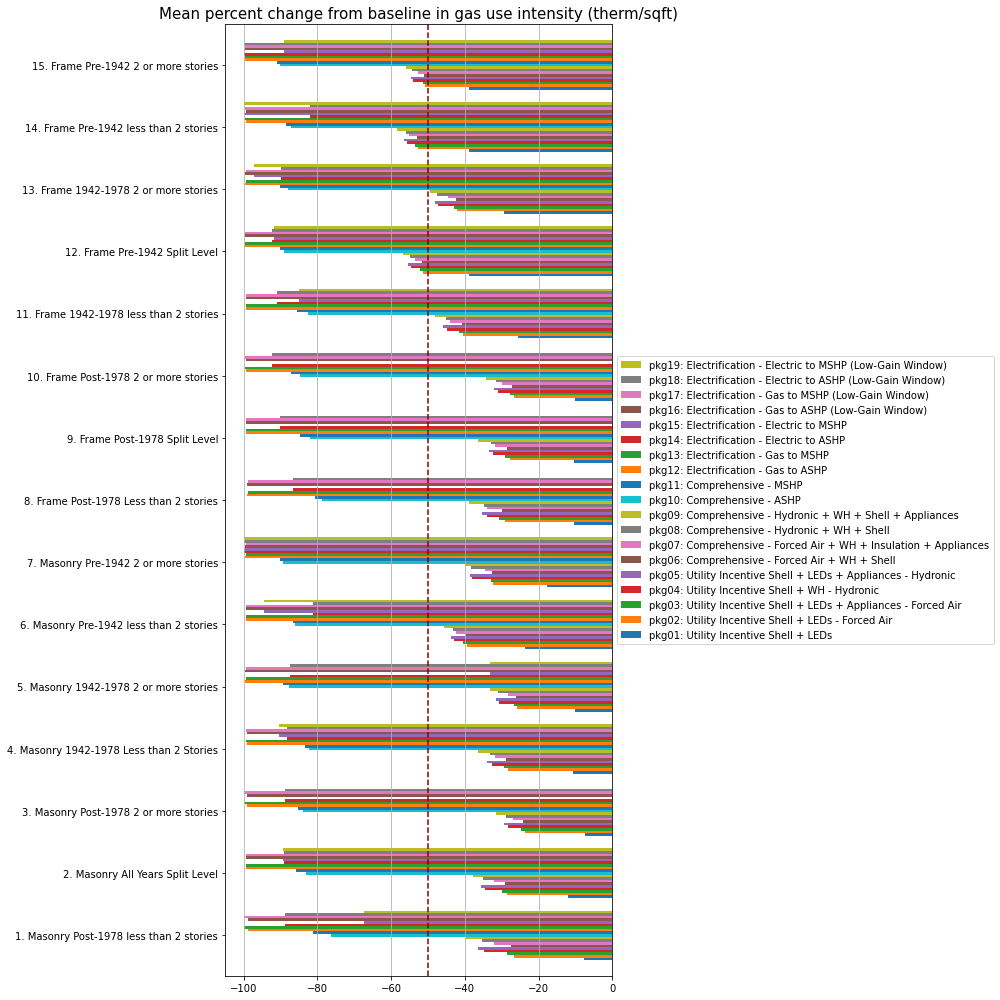

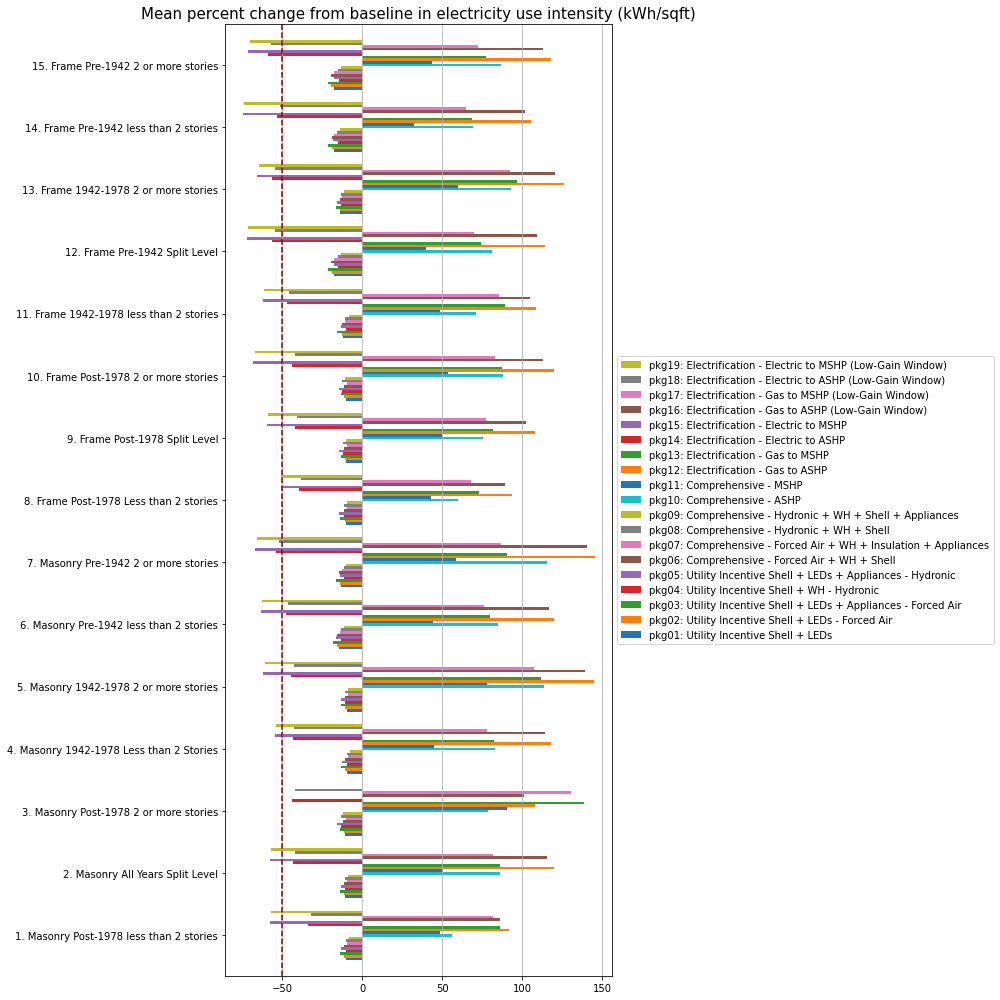

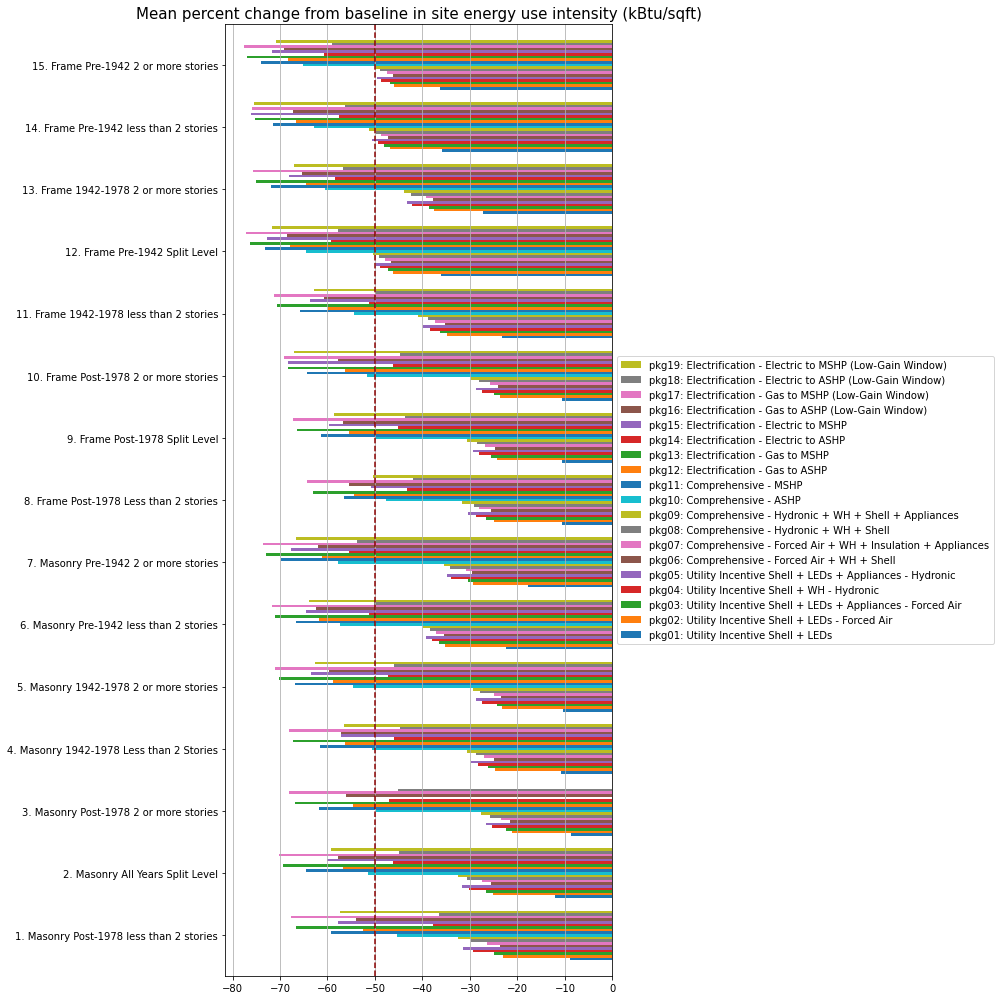

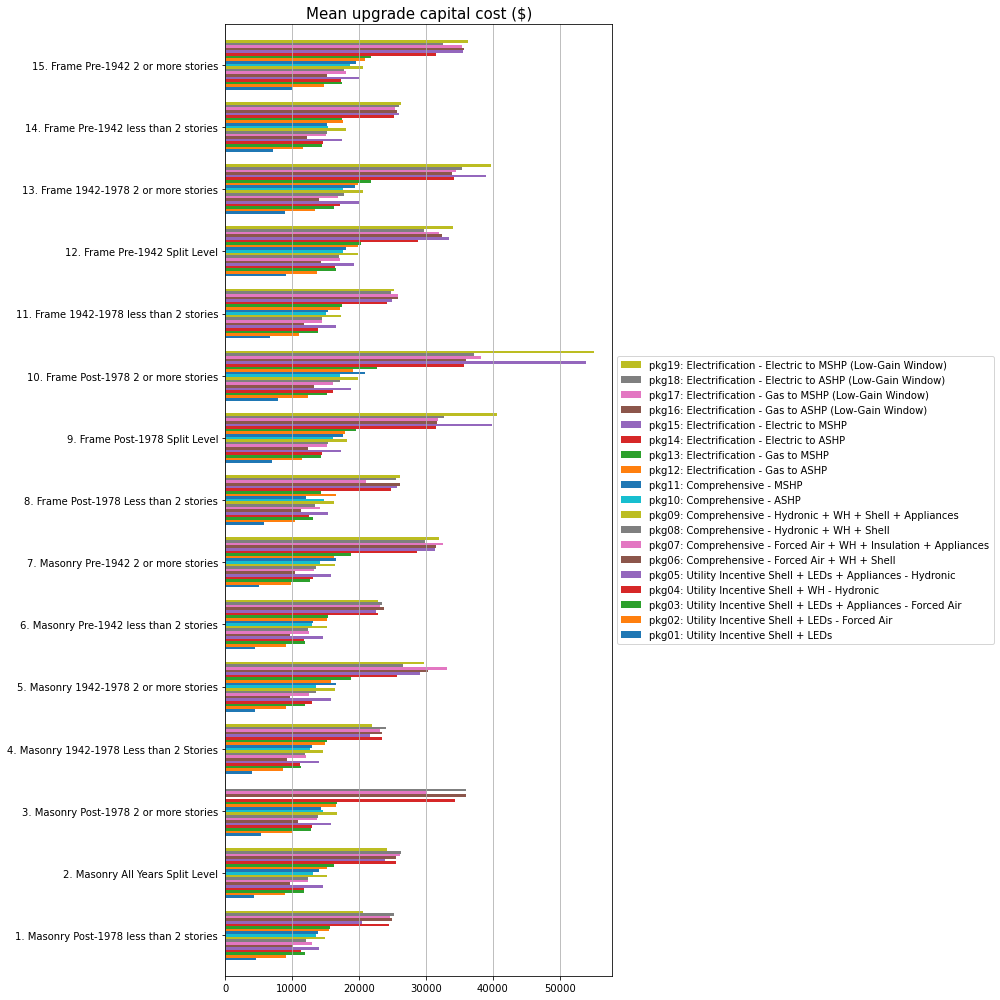

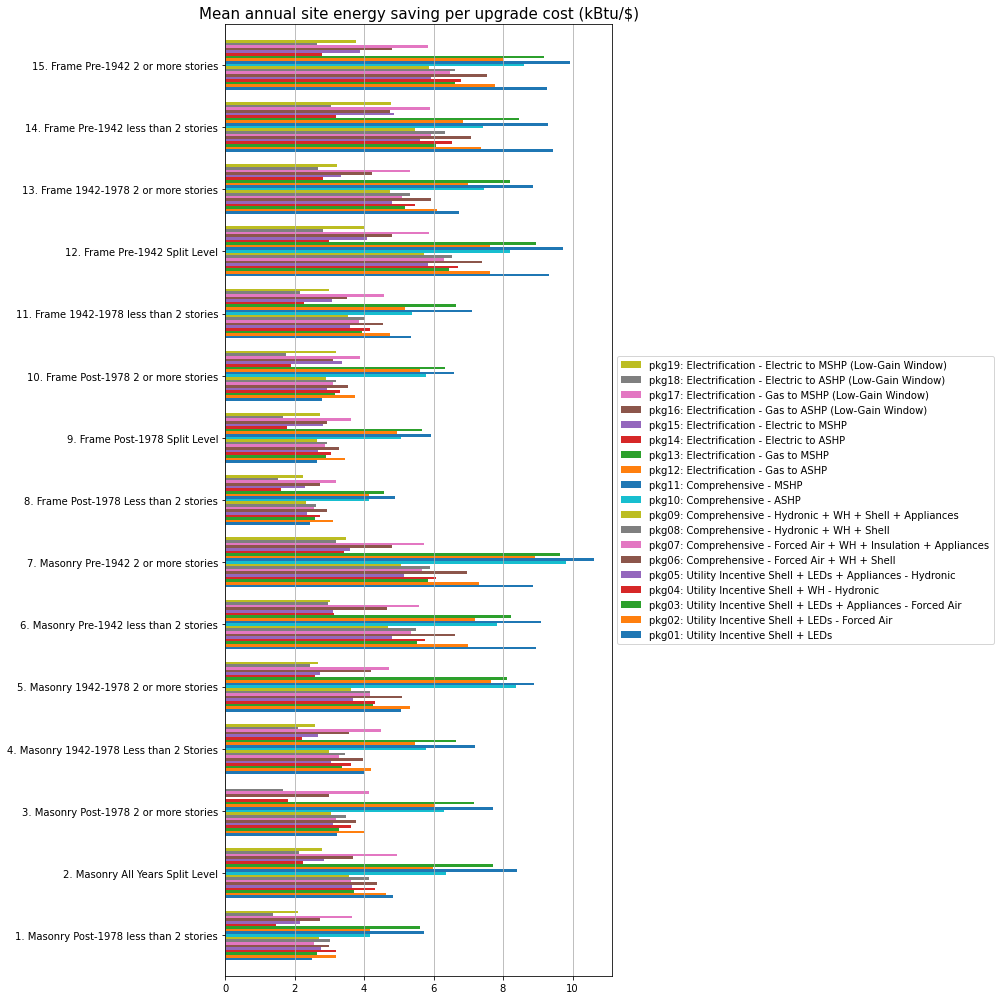

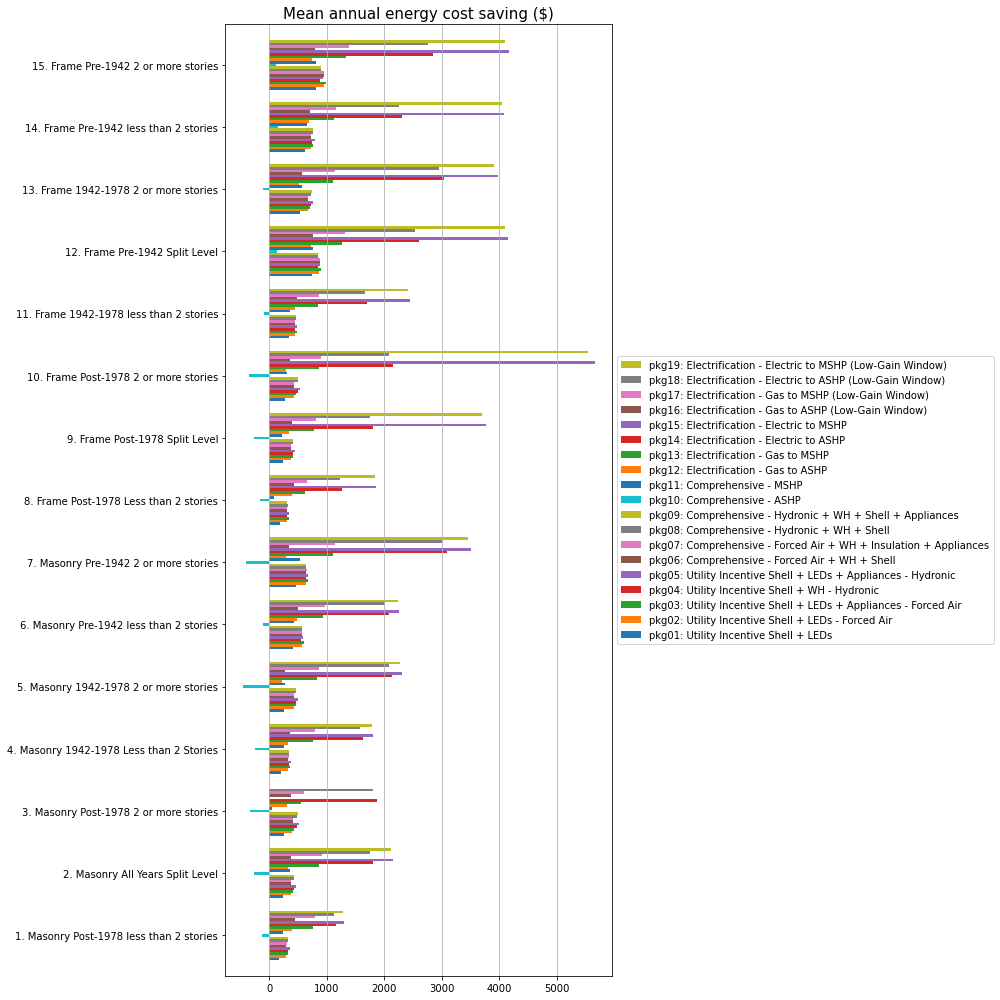

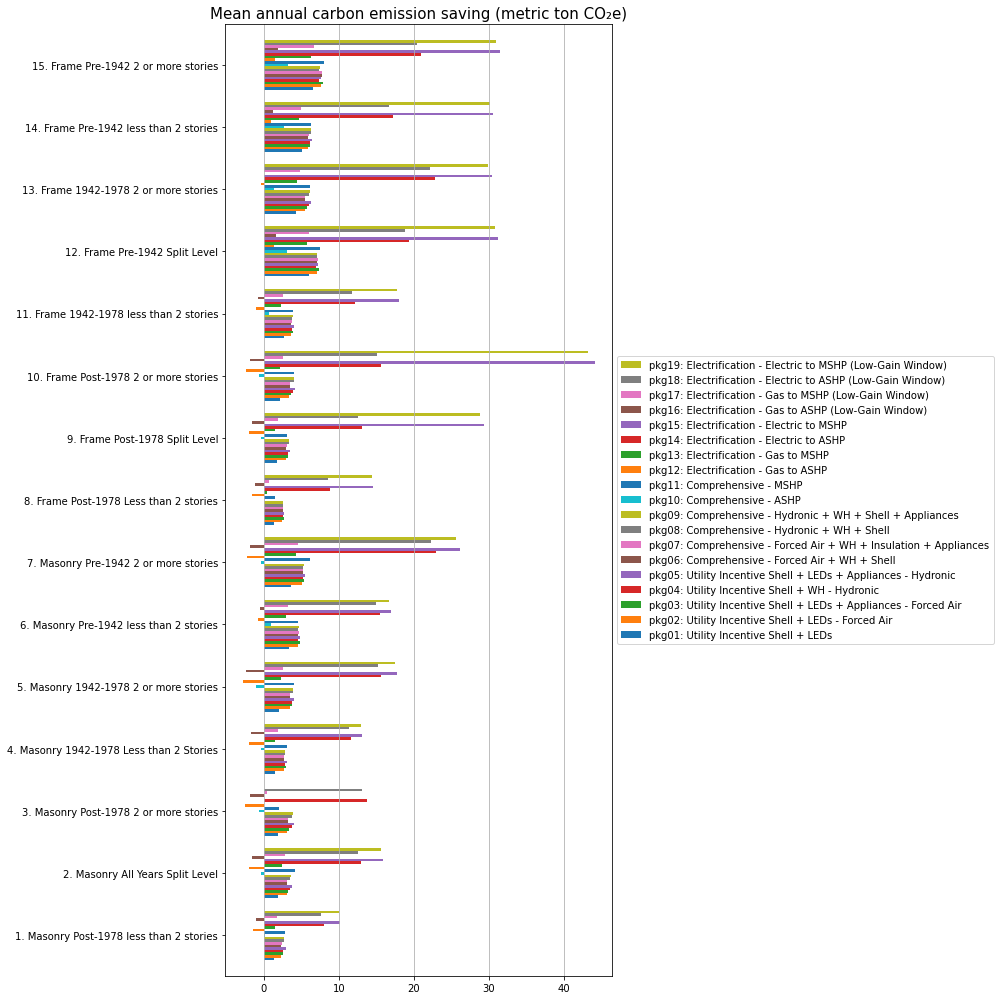

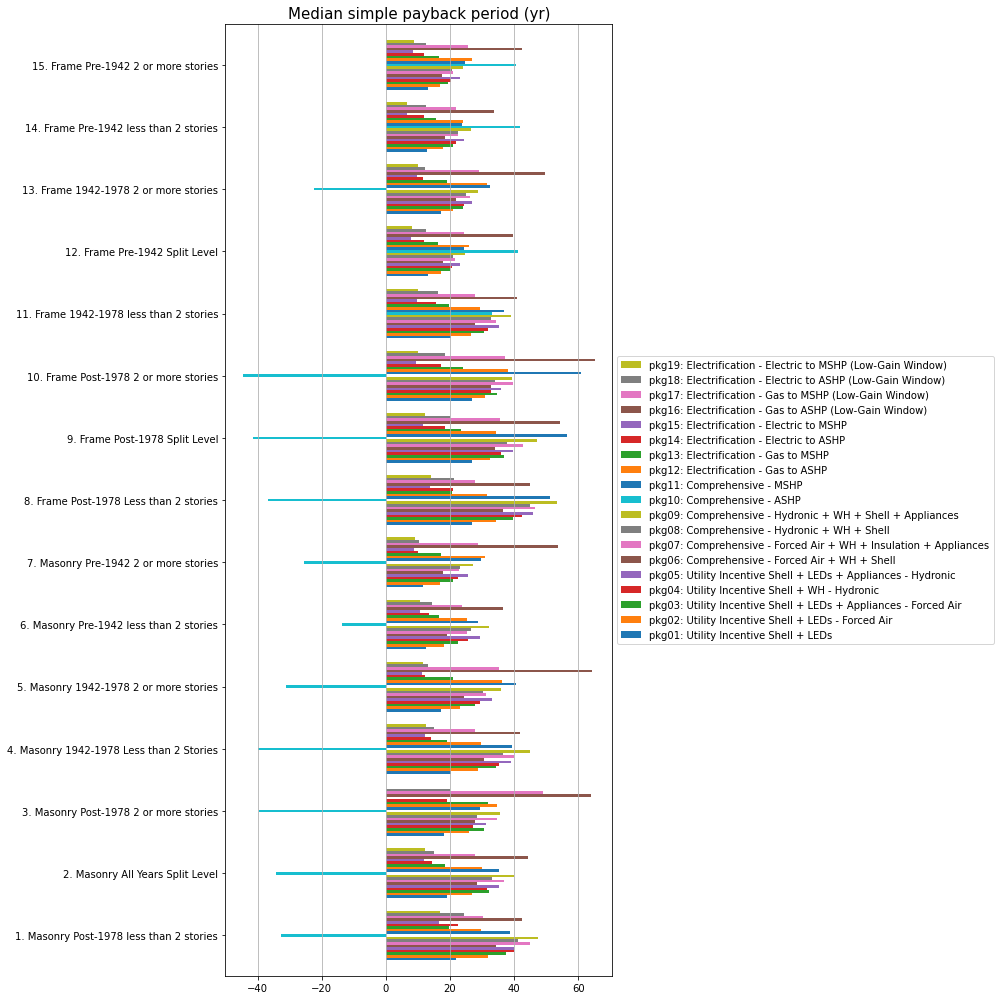

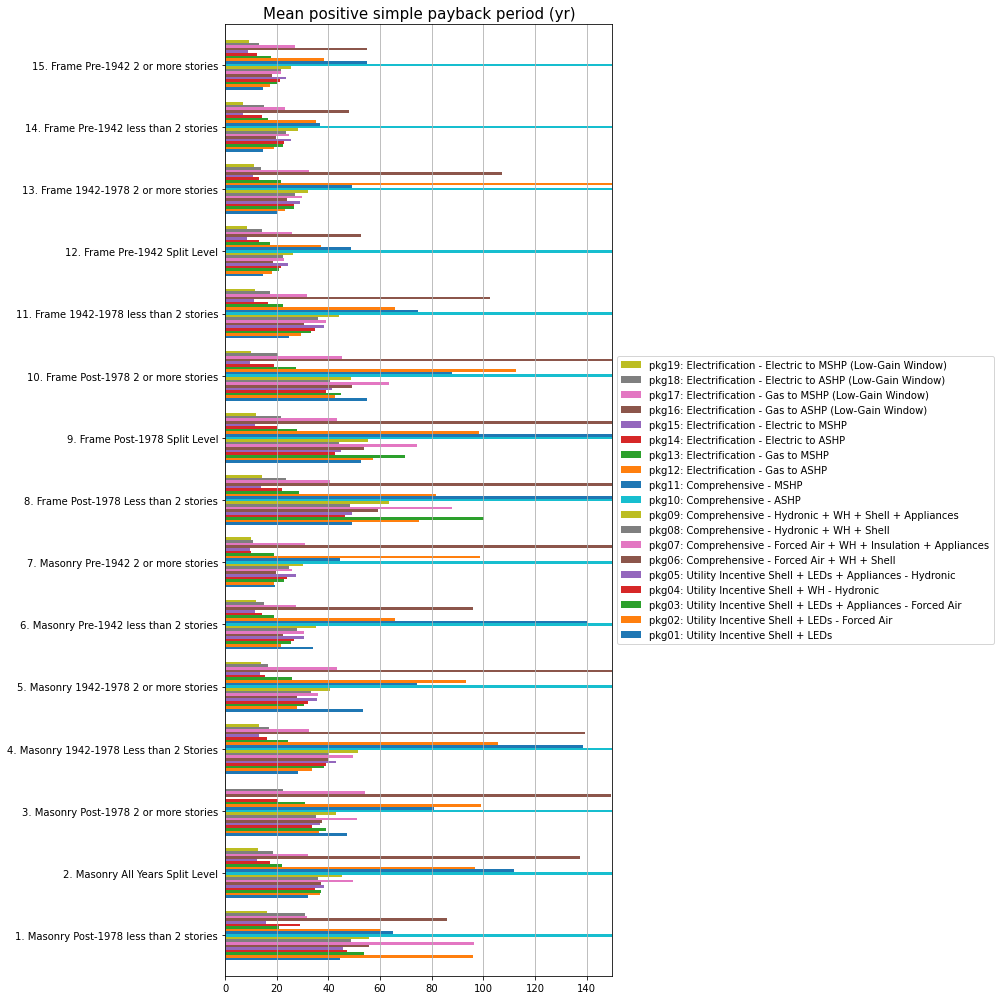

In [172]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

zoom_in_plots = False # <-------

zoom_in_xlimits = {
    'mean_pct_delta_gas_eui': [None, None],
    'mean_pct_delta_elec_eui': [None, None],
    'mean_pct_delta_site_eui': [-25, None],
    'mean_upgrade_cost': [None, 10000],
    'mean_ann_kbtu_saved_per_dollar': [None, 500],
    'mean_ann_energy_cost_saving': [None, 2000],
    'mean_ann_metric_ton_co2e_saving': [None, 20],
    'median_simple_payback': [-70, 70],
}

# create subfolder for plots:
plot_path1 = os.path.join(plot_path, 'mean_values_by_prototype')
if not os.path.exists(plot_path1):
    os.mkdir(plot_path1)
print(f'plot dir: {plot_path1}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

if NG_rate_multiplier == 1:
    para_labels = {
        'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
        'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
        'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
        'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
        'mean_ann_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)',
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'mean_ann_metric_ton_co2e_saving': f'Mean annual carbon emission saving (metric ton CO₂e)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }
else:
    para_labels = {
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }

    
for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    zoom_ext = ''
    if zoom_in_plots:
        if len(list(x for x in zoom_in_xlimits[para_to_plot] if x is not None))>0:
            zoom_ext = '_zoomed'
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}{zoom_ext}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPi = groups2.set_index(idx)[para_to_plot]
    xmin = UPi.replace([np.inf, -np.inf], np.nan).min().min()
    xmax = UPi.replace([np.inf, -np.inf], np.nan).max().max()

    fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(14, 14))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg21)
    # Group 1A: (upg01-upg10) N=10
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(para_label, fontsize=15, y=1)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')
    ax.margins(y=0)
    
    if zoom_in_plots:
        [xmin, xmax] = zoom_in_xlimits[para_to_plot]
        if xmin is not None:
            ax.set_xlim(left = xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
            
    if para_to_plot in ['median_simple_payback', 'mean_pos_simple_payback']:
        if xmax >= 150:
            ax.set_xlim(0,150)
    
    plt.tight_layout()
    
    filename = f'{iter_path}-comparison_{para_to_plot}{fn_ext}.pdf'
    fig.savefig(os.path.join(plot_path1, filename),
                bbox_inches='tight')


#### 2.3.2. plot mean values for Chicago avg per SFD

In [173]:
Wtchicago = groups2.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_avg = groups2.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_avg.index.name = groups_avg.index.name[1]
groups_avg = groups_avg.stack(level=0).stack().unstack(level=0)
groups_avg['Chicago avg'] = np.where(np.isnan(groups_avg),0,groups_avg).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']].copy()
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_avg = groups_avg.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_avg['upgrade_no'] = groups_avg['upgrade_no'].str[3:5].astype(int)
groups_avg['upgrade_name'] = groups_avg['upgrade_no'].map(upgrade_name_map)
groups_avg = groups_avg.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

### save a copy
groups_avg.to_csv(os.path.join(result_path,
                               'processed results',
                               f'upgrades_prototype_chicago_avg_results{fn_ext}.csv'),
                  index=True)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
groups_avg

Natural gas rate multiplier: 1


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg
0,mean_ann_energy_cost_saving,1,Utility Incentive Shell + LEDs,539.070,344.920,275.880,184.030,235.240,811.88,751.16,628.090,255.840,197.010,248.900,255.070,174.890,467.270,421.990,403.758058
1,mean_ann_energy_cost_saving,2,Utility Incentive Shell + LEDs - Forced Air,669.800,446.970,425.460,306.160,372.070,948.04,874.87,723.930,428.870,328.290,378.800,402.970,291.140,642.280,568.290,544.541541
2,mean_ann_energy_cost_saving,3,Utility Incentive Shell + LEDs + Appliances - ...,706.890,482.820,462.920,343.470,409.460,983.51,910.03,758.470,465.760,364.870,415.380,439.560,328.650,678.750,603.290,581.053603
3,mean_ann_energy_cost_saving,4,Utility Incentive Shell + WH - Hydronic,728.960,456.770,496.240,313.690,412.640,892.46,848.08,752.600,466.400,342.150,429.090,479.700,321.860,637.260,561.030,547.915825
4,mean_ann_energy_cost_saving,5,Utility Incentive Shell + LEDs + Appliances - ...,769.210,491.180,528.810,347.870,445.950,928.59,884.30,789.010,502.860,379.240,466.490,518.810,367.450,675.720,596.400,584.100220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,pct_pos_simple_payback,15,Electrification - Electric to MSHP,100.000,100.000,100.000,100.000,100.000,100.00,100.00,100.000,100.000,100.000,100.000,NaN,100.000,100.000,100.000,98.598599
186,pct_pos_simple_payback,16,Electrification - Gas to ASHP (Low-Gain Window),94.094,91.910,88.158,92.599,90.145,98.37,98.17,97.758,84.281,86.245,86.801,88.421,93.271,82.435,90.625,90.343958
187,pct_pos_simple_payback,17,Electrification - Gas to MSHP (Low-Gain Window),100.000,99.684,100.000,100.000,100.000,100.00,100.00,100.000,98.810,99.849,99.842,100.000,100.000,100.000,100.000,99.974692
188,pct_pos_simple_payback,18,Electrification - Electric to ASHP (Low-Gain W...,100.000,100.000,100.000,100.000,100.000,100.00,100.00,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000000


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_elevate_all/processed results/plots/mean_values_chicago_avg

Plotting Chicago avg: mean_ann_energy_cost_saving...
    - Group1
Plotting Chicago avg: mean_ann_kbtu_saved_per_dollar...
    - Group1
Plotting Chicago avg: mean_ann_metric_ton_co2e_saving...
    - Group1
Plotting Chicago avg: mean_pct_delta_elec_eui...
    - Group1
Plotting Chicago avg: mean_pct_delta_gas_eui...
    - Group1
Plotting Chicago avg: mean_pct_delta_site_eui...
    - Group1
Plotting Chicago avg: mean_pos_simple_payback...
    - Group1
Plotting Chicago avg: mean_upgrade_cost...
    - Group1
Plotting Chicago avg: median_simple_payback...
    - Group1
Plotting Chicago avg: pct_pos_simple_payback...
    - Group1


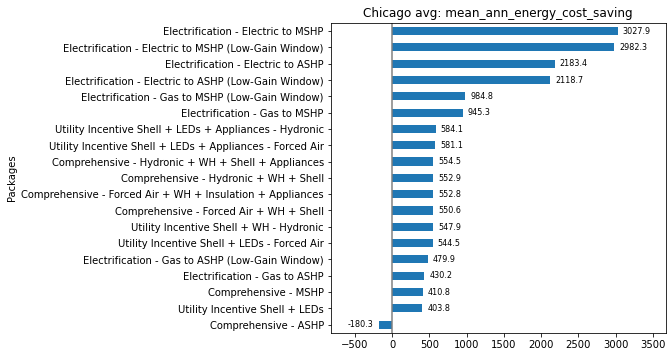

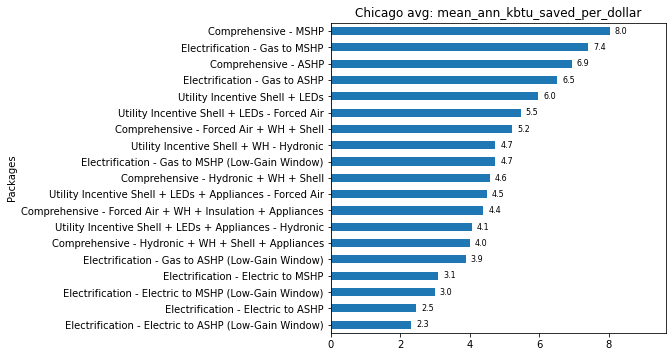

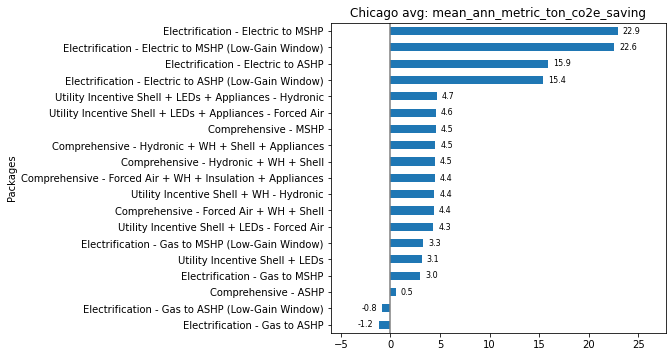

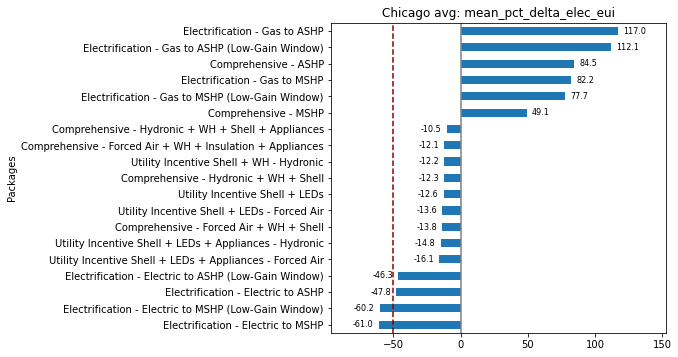

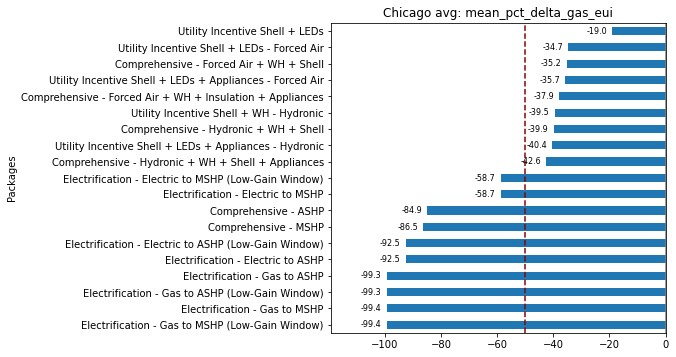

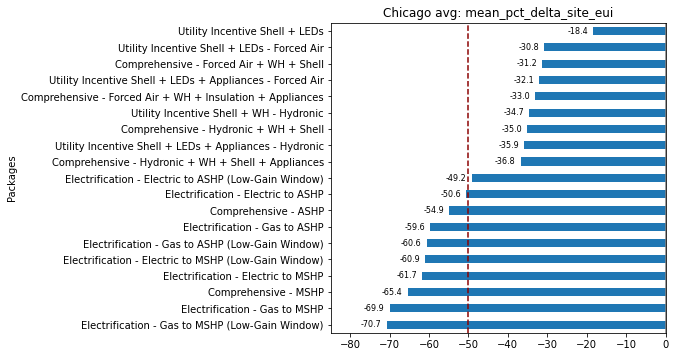

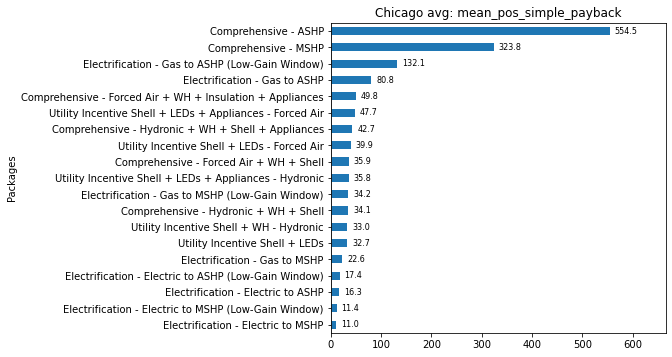

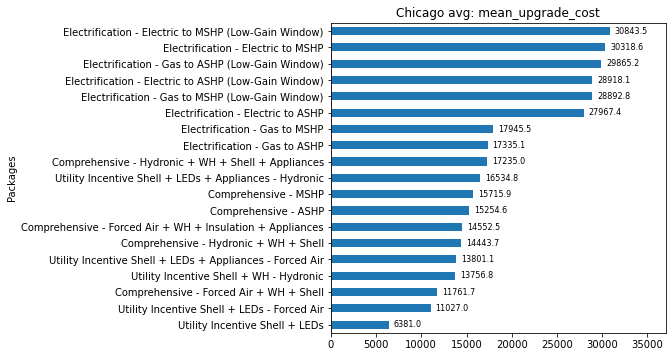

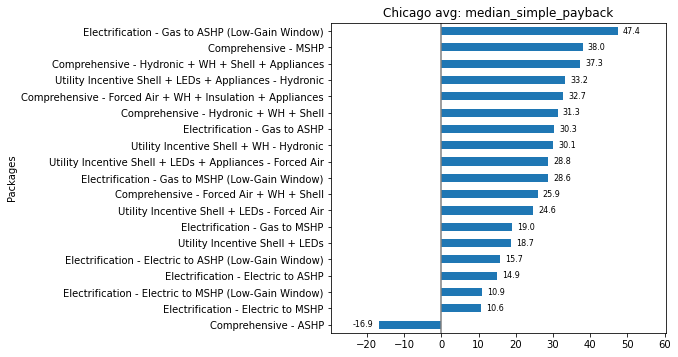

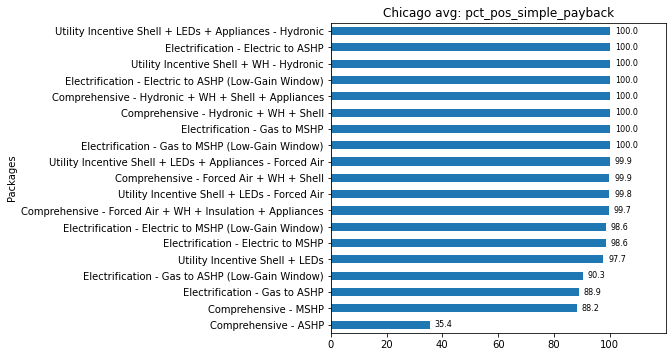

In [174]:
para_to_plot = 'Chicago avg' # <------

upgrade_sets = {
    'Packages': range(1, N_upgrades+1),
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path2 = os.path.join(plot_path, 'mean_values_chicago_avg')
if not os.path.exists(plot_path2):
    os.mkdir(plot_path2)
print(f'plot dir: {plot_path2}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_avg['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 'median_simple_payback']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot}: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_avg[(groups_avg['metrics']==metric) & 
                              (groups_avg['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path2, filename),
                    bbox_inches='tight')
        

#### 2.3.4. plot metrics distribution
Run cell below to load df for plots

In [176]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    all_proto_upgrades = pd.read_csv(os.path.join(result_path, 'processed results', 'all_upgrades_by_prototype_combined.csv'))
    
    print(f'"all_proto_upgrades{fn_ext}" df loaded from file.')
    N_upgrades = all_proto_upgrades['package_no'].unique().max()
    print(f'   total number of packages: {N_upgrades}')
    
    display(all_proto_upgrades)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_elevate_all/processed results/plots/distribution_by_prototype

>> 1. plotting pct_delta_gas_eui...
>> 2. plotting pct_delta_elec_eui...
>> 3. plotting pct_delta_site_eui...
>> 4. plotting upgrade_cost...
>> 5. plotting ann_kbtu_saved_per_dollar...
>> 6. plotting ann_energy_cost_saving...
>> 7. plotting ann_metric_ton_co2e_saving...
>> 8. plotting simple_payback...


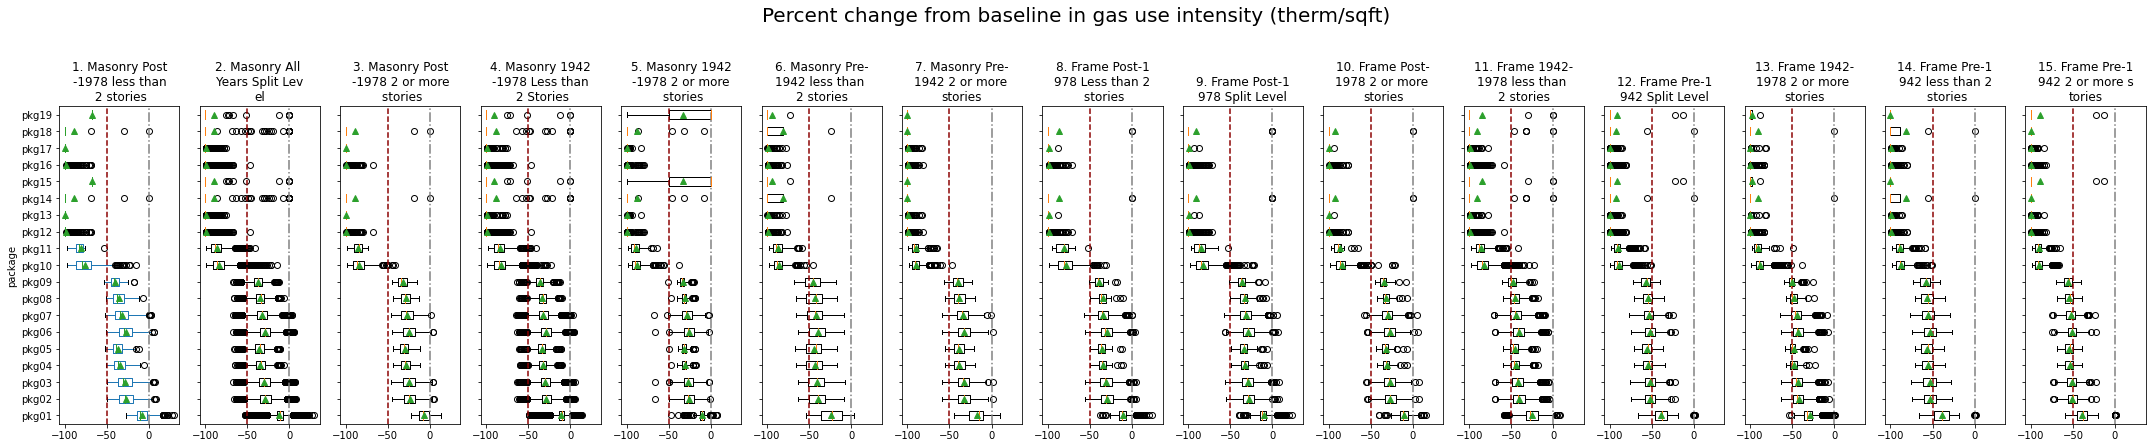

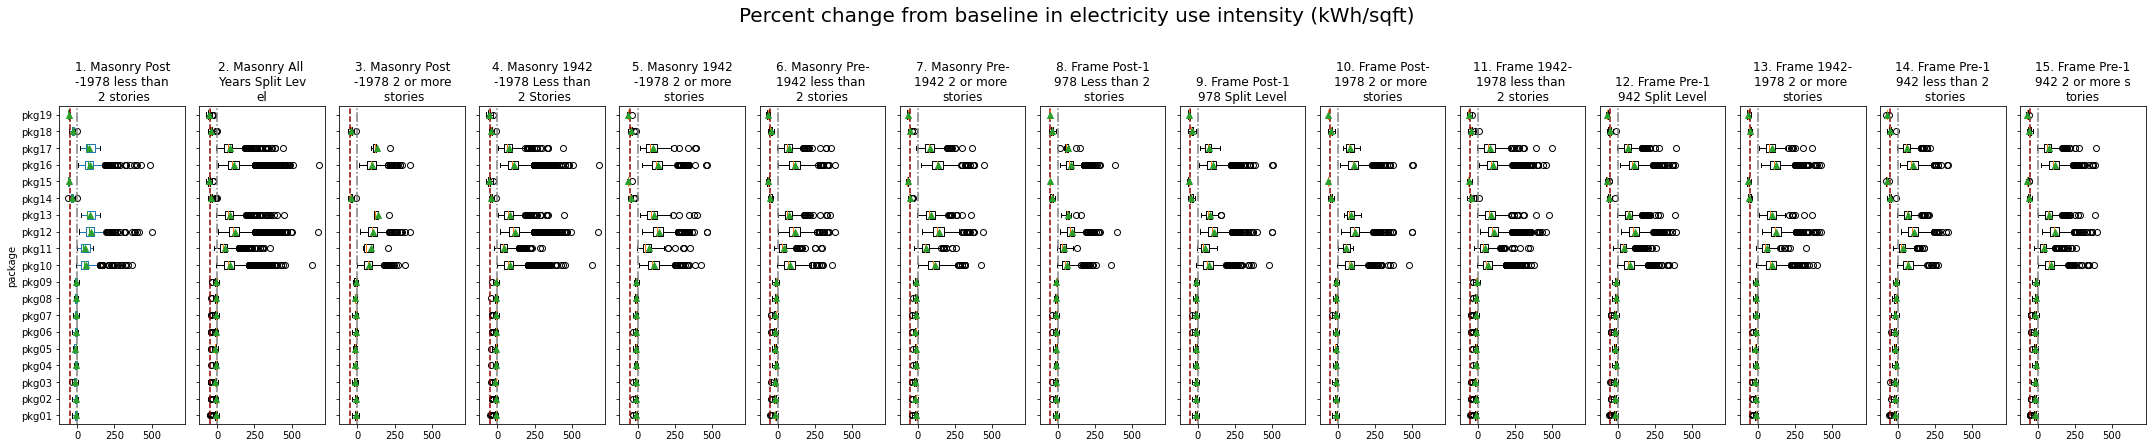

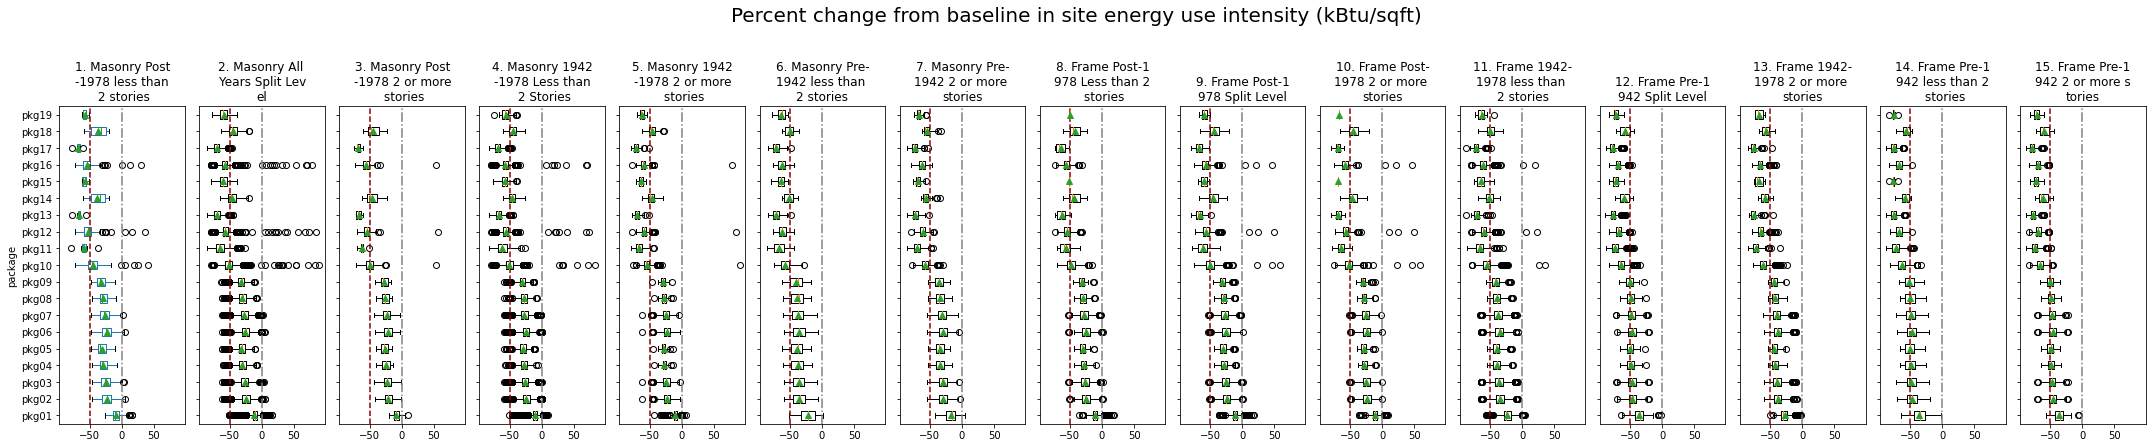

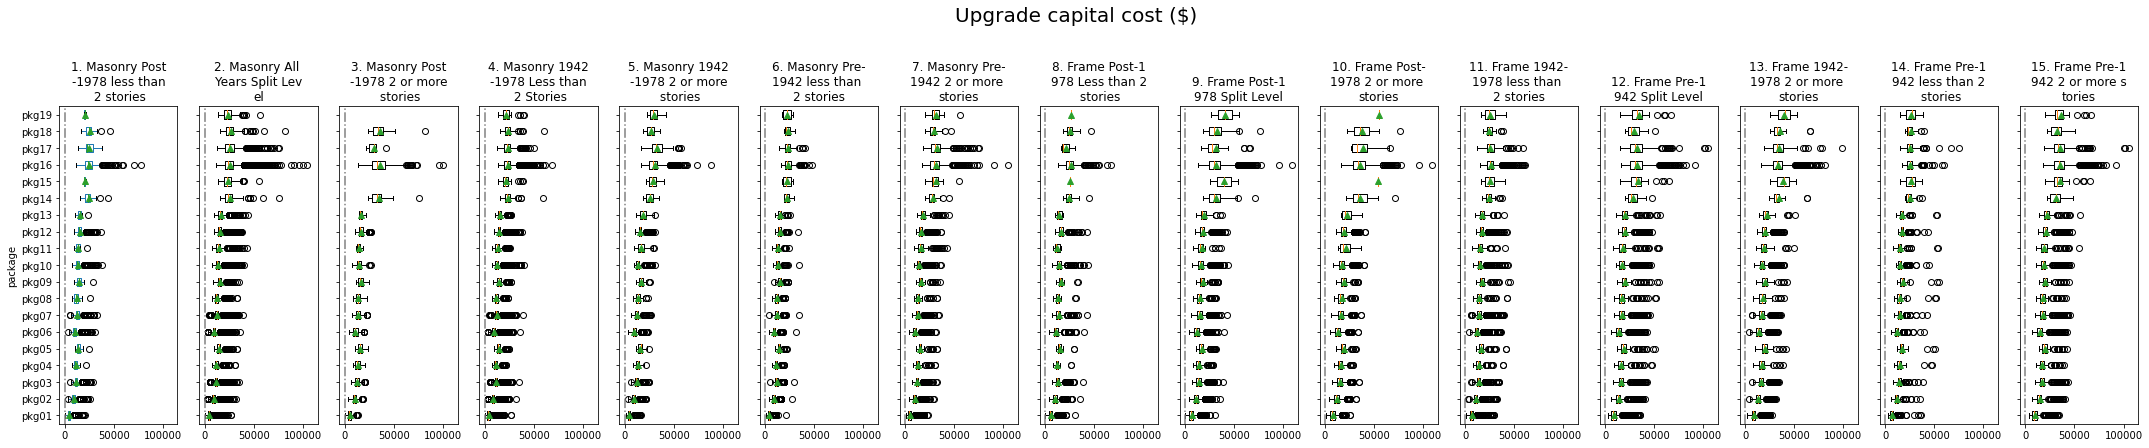

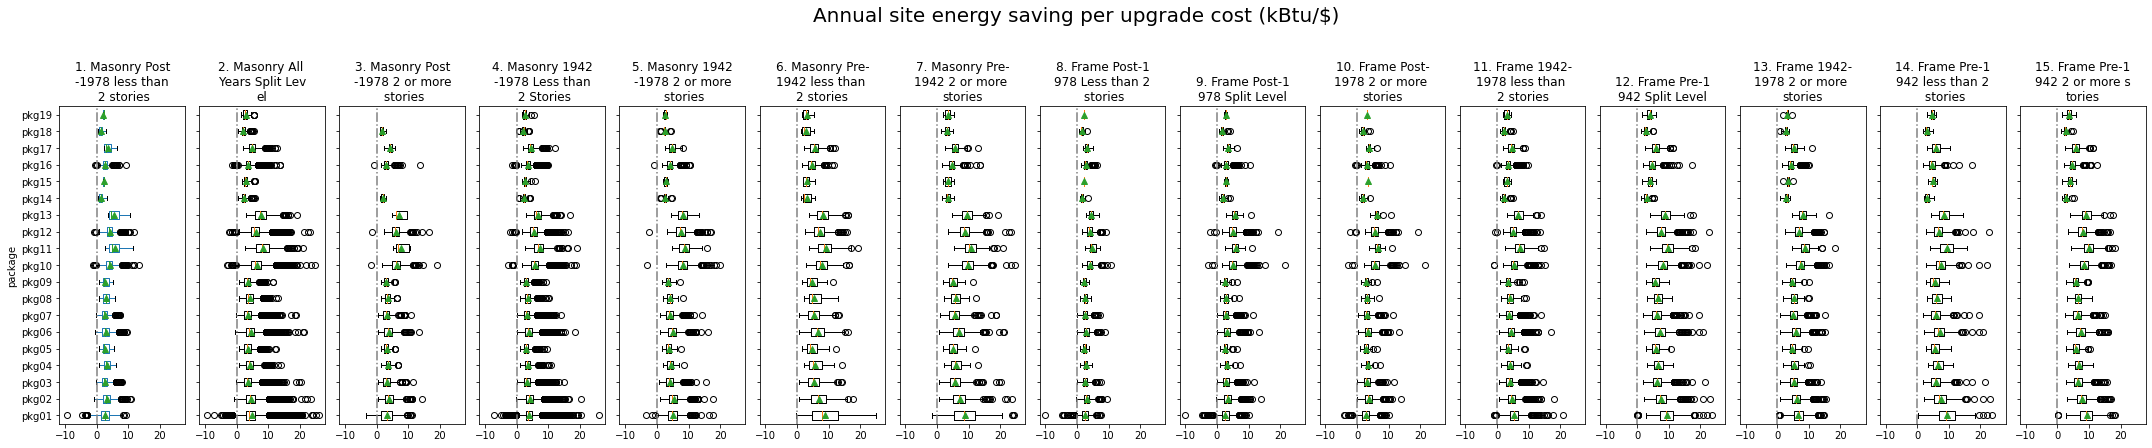

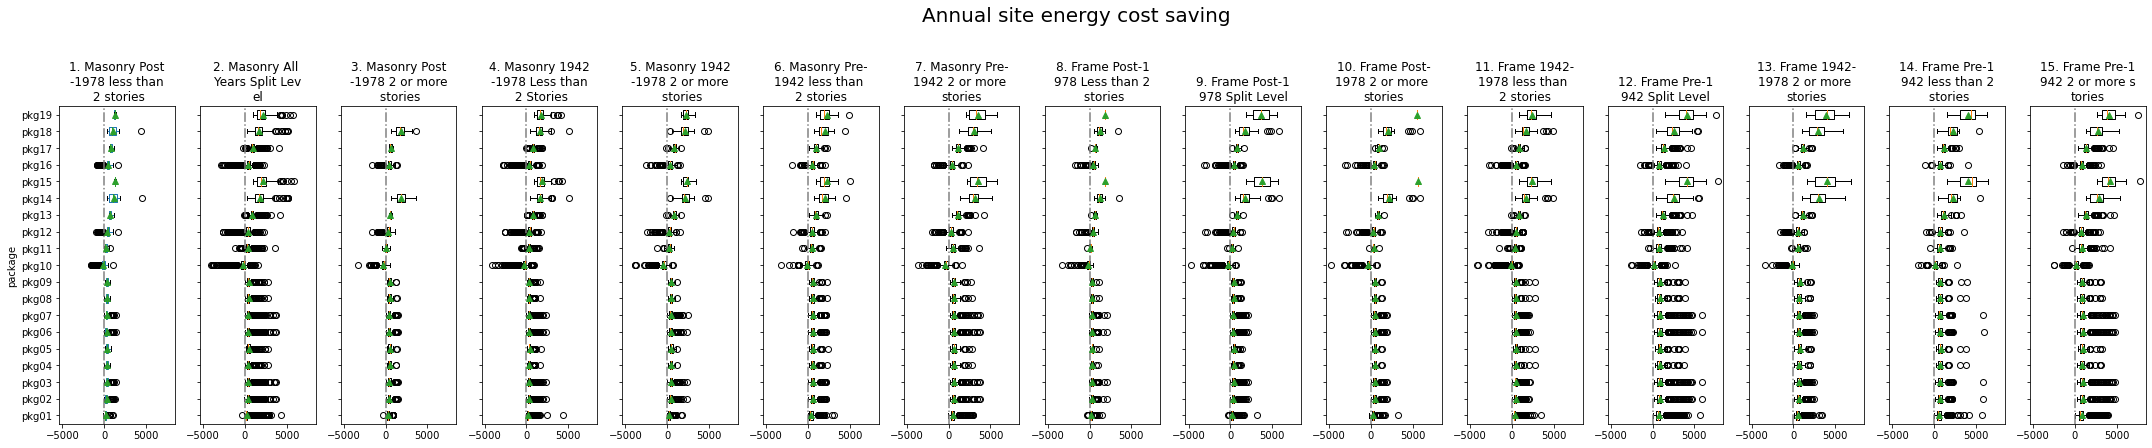

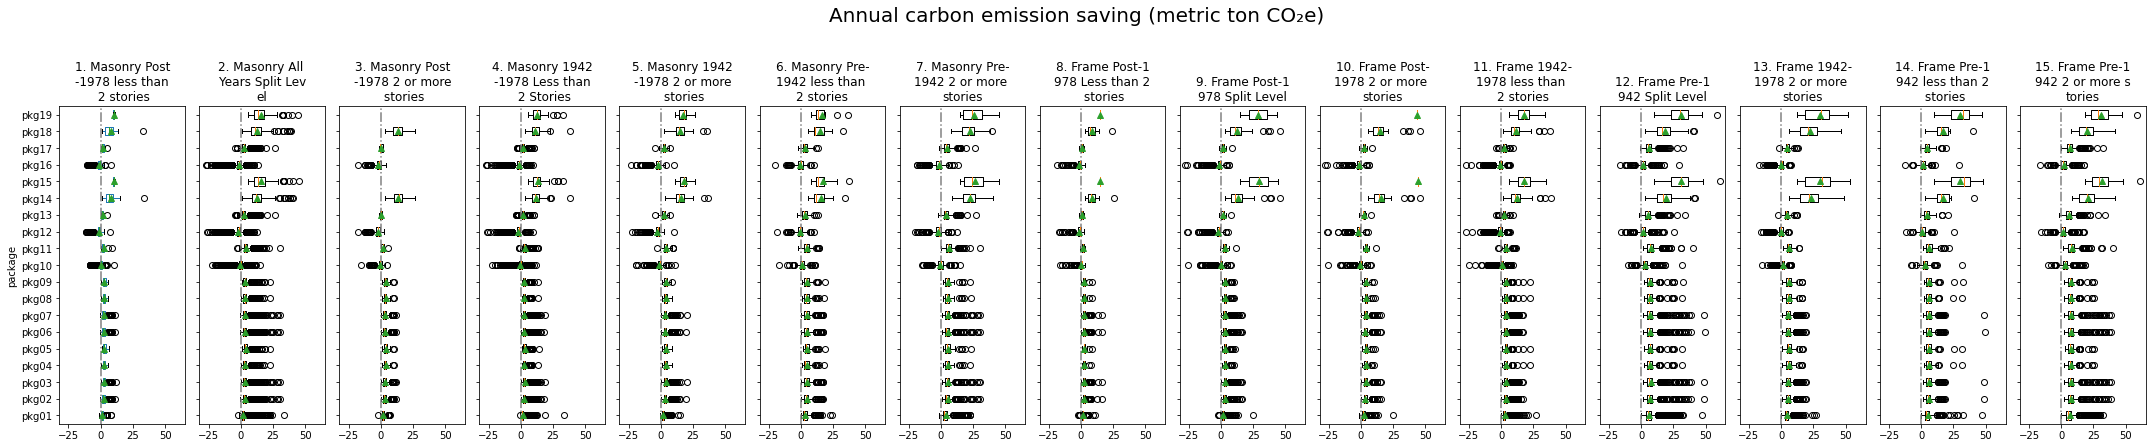

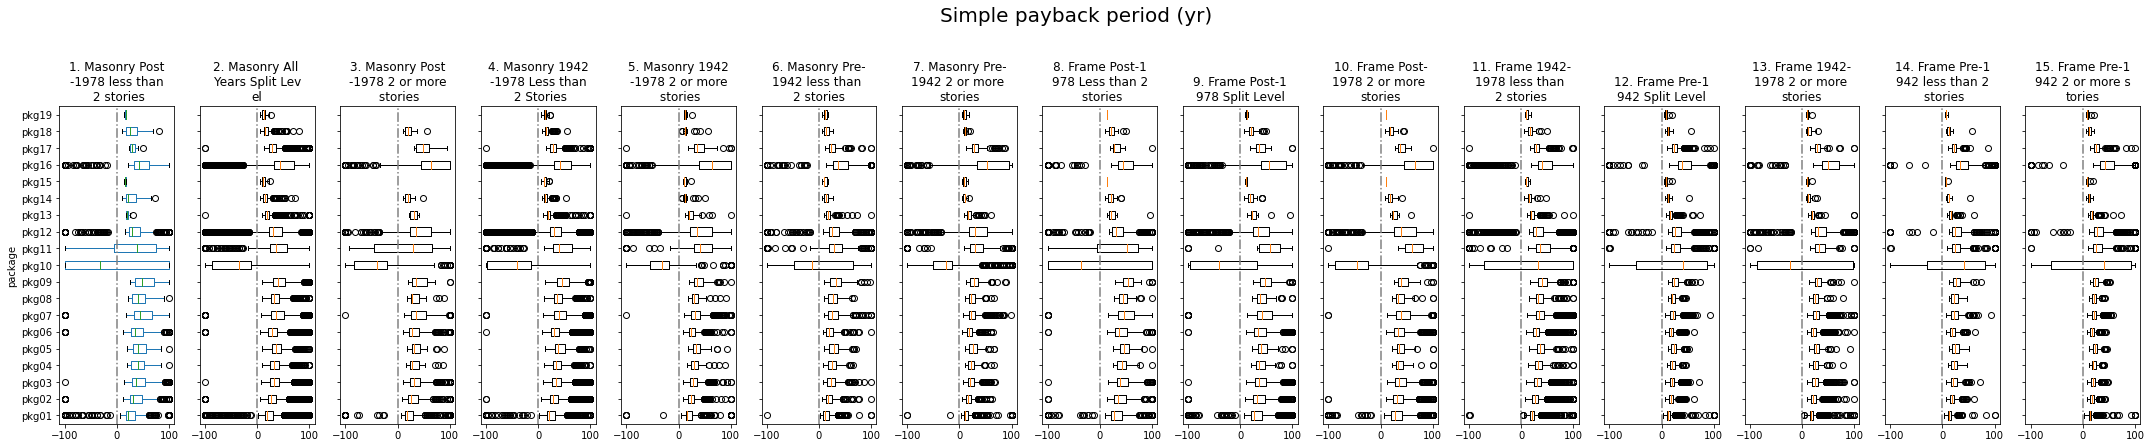

In [177]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

# create subfolder for plots:
plot_path4 = os.path.join(plot_path, 'distribution_by_prototype')
if not os.path.exists(plot_path4):
    os.mkdir(plot_path4)
print(f'plot dir: {plot_path4}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

## modifying payback periods, cap either ends at [100,-100] 
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']>100]).index,
                       'simple_payback'] = 100
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']<-100]).index,
                       'simple_payback'] = -100

if NG_rate_multiplier == 1:
    para_labels = {
        'pct_delta_gas_eui': 'Percent change from baseline in gas use intensity (therm/sqft)',
        'pct_delta_elec_eui': 'Percent change from baseline in electricity use intensity (kWh/sqft)',
        'pct_delta_site_eui': 'Percent change from baseline in site energy use intensity (kBtu/sqft)',
        'upgrade_cost': 'Upgrade capital cost ($)',
        'ann_kbtu_saved_per_dollar': 'Annual site energy saving per upgrade cost (kBtu/$)',
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'ann_metric_ton_co2e_saving': f'Annual carbon emission saving (metric ton CO₂e)',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }
else:
    para_labels = {
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }

cols_to_match = list(f'pkg{n:02d}' for n in range(1,N_upgrades+1))

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}...')
    xmin = all_proto_upgrades[para_to_plot].min(); xmax = all_proto_upgrades[para_to_plot].max()
    
    fig, axes = plt.subplots(ncols=15, nrows=1, sharex=True, sharey=True, figsize=(30, 6))
    for h in range(1,16):
        ax = axes[h-1]
        p = all_proto_upgrades.query('HousingGroupNo==@h')[['HousingGroupNo','HousingGroupName',
                                                            'package_no', para_to_plot]]
        lab = f'{p["HousingGroupNo"].iloc[0]}. {p["HousingGroupName"].iloc[0]}'
        lab = '\n'.join([lab[i:i+15] for i in range(0, len(lab), 15)]) # break up long string
        p.loc[:,'package_no'] = 'pkg'+p['package_no'].astype(str).str.zfill(2)
        p = p.sort_values(by='package_no')
        p = p.set_index([p.index, 'package_no'])[
            para_to_plot].unstack(level=-1).dropna(
            axis=0, how='all')
        
        ### show all upgrades
        for col in set(cols_to_match)-set(p.columns):
            p[col] = np.nan
        p = p.sort_index(axis=1).reset_index(drop=True)
    
        if para_to_plot == 'simple_payback':
            showmeans = False
        else:
            showmeans = True
            
        try:
            p.boxplot(ax=ax, vert=False, grid=False, showmeans=showmeans)
        except:
            pass

        ax.set_title(lab)
        if h==1:
            ax.set_ylabel('package')
        ax.axvline(x=0, linestyle='-.', color='gray')
        if (para_to_plot[-3:]=='eui') & (xmin < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
            
        ax.set_yticks(range(1, 1+N_upgrades))
        ax.set_yticklabels(cols_to_match)
        
    para_label = para_labels[para_to_plot]
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    
    filename = os.path.join(plot_path4, f'{iter_path}-distribution_{para_to_plot}{fn_ext}.pdf')
    fig.savefig(filename, bbox_inches='tight')
